In [1]:
import sys
sys.path.append('..') # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Reshape, Conv1D, Conv2D, Conv3D, Flatten, MaxPooling1D, AveragePooling1D,
    BatchNormalization, Concatenate, Activation, Rescaling, Add, Subtract, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from scipy.stats import norm
from scikeras.wrappers import KerasRegressor
from functools import partial
import tensorflow_addons as tfa

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)


2022-10-21 16:01:19.925414: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-21 16:01:20.083762: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-21 16:01:20.083788: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-10-21 16:01:20.117386: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-21 16:01:20.812306: W tensorflow/stream_executor/platform/de

In [10]:
# symbols = 'BTC,ETH'.split(',')
symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
df = fetch_ohlcv(symbols=symbols, with_target=True, price_type=None)
df.to_pickle('/tmp/df_price_type_none.pkl')
display(df)

op           hi           lo  \
timestamp                 symbol                                           
2019-07-20 12:00:00+00:00 BNB        30.722500     30.77250     30.62500   
                          BTC     10564.250000  10630.00000  10525.50000   
                          ETH       225.930000    226.44000    225.51000   
                          XRP         0.327975      0.32840      0.32700   
2019-07-20 13:00:00+00:00 BNB        30.625000     30.86750     30.33500   
...                                        ...          ...          ...   
2022-10-21 09:00:00+00:00 ETH      1277.700000   1281.80000   1272.40000   
                          LINK        6.511000      6.57300      6.46150   
                          MATIC       0.797700      0.80080      0.78910   
                          SOL        27.480000     27.60000     27.20250   
                          XRP         0.439450      0.44265      0.43805   

                                            cl        volume  \
timestamp                 symbol                               
2019-07-20 12:00:00+00:00 BNB        30.625000  2.215166e+04   
                          BTC     10539.500000  1.052997e+07   
                          ETH       225.830000  0.000000e+00   
                          XRP         0.327975  0.000000e+00   
2019-07-20 13:00:00+00:00 BNB        30.562500  1.649716e+05   
...                                        ...           ...   
2022-10-21 09:00:00+00:00 ETH      1280.200000  5.035840e+07   
                          LINK        6.558000  1.082293e+06   
                          MATIC       0.796500  4.192378e+06   
                          SOL        27.540000  2.082210e+07   
                          XRP         0.442275  3.336442e+06   

                                        execution_start_at       ret  
timestamp                 symbol                                      
2019-07-20 12:00:00+00:00 BNB    2019-07-20 13:00:00+00:00 -0.020256  
                          BTC    2019-07-20 13:00:00+00:00 -0.001922  
                          ETH    2019-07-20 13:00:00+00:00 -0.011953  
                          XRP    2019-07-20 13:00:00+00:00 -0.008708  
2019-07-20 13:00:00+00:00 BNB    2019-07-20 14:00:00+00:00 -0.026494  
...                                                    ...       ...  
2022-10-21 09:00:00+00:00 ETH    2022-10-21 10:00:00+00:00       NaN  
                          LINK   2022-10-21 10:00:00+00:00       NaN  
                          MATIC  2022-10-21 10:00:00+00:00       NaN  
                          SOL    2022-10-21 10:00:00+00:00       NaN  
                          XRP    2022-10-21 10:00:00+00:00       NaN  

[257448 rows x 7 columns]

In [2]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype
import pandas_ta as ta

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7
    
    df['beta_weight'] = 1
    # df['beta_weight'] = 1 + df.groupby('symbol')['volume'].transform(lambda x: x.rolling(24 * 7, 1).mean())
    
    def beta_mean(col):
        return (df[col] * df['beta_weight']).groupby('timestamp').transform('mean') / df.groupby('timestamp')['beta_weight'].transform('mean')

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ln_cl_diff_mean'] = beta_mean('ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    df['beta'] = (
        (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
        / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    ).fillna(0).clip(0.1, 2.0)
    # df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
    
    if with_ret:
        ret_mean = df.groupby('timestamp')['ret'].transform('mean')
        ret_mean = beta_mean('ret')
        dfs += [
            (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
    
    for col in get_feature_columns(df):
        feature_mean = beta_mean(col)
        dfs += [
            (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)
    
    # dfs = [df]
    # for col in get_feature_columns(df):
    #     if '_symbolbeta' not in col:
    #         continue
    #     dfs += [
    #         (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
    #     ]
    # df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    df['Open'] = df['op']
    df['High'] = df['hi']
    df['Low'] = df['lo']
    df['Close'] = df['cl']
    
    def adx(t):
        return (talib.ADX(high, low, close, timeperiod=t) / 100).fillna(0)

    def adxr(t):
        return (talib.ADXR(high, low, close, timeperiod=t) / 100).fillna(0)

    def rsi(t):
        return signed_rsi_sma(close, timeperiod=t).fillna(0)

    def rsi_hilo(t):
        return signed_rsi_sma(0.5 * (high + low), timeperiod=t).fillna(0)

    def rsi_volume(t):
        return signed_rsi_sma(volume, timeperiod=t).fillna(0)

    def aroon_down(t):
        return (talib.AROON(high, low, timeperiod=t)[0] / 100).fillna(0)
    def aroon_up(t):
        return (talib.AROON(high, low, timeperiod=t)[1] / 100).fillna(0)

    def aroonosc(t):
        return (talib.AROONOSC(high, low, timeperiod=t) / 100).fillna(0)

    def cci(t):
        return talib.CCI(high, low, close, timeperiod=t).fillna(0)

    def cmo(t):
        return talib.CMO(close, timeperiod=t).fillna(0)

    def dx(t):
        return (talib.DX(high, low, close, timeperiod=t) / 100).fillna(0)

    def mfi(t):
        return (talib.MFI(high, low, close, volume, timeperiod=t) / 50 - 1).fillna(0)

    def trix(t):
        return talib.TRIX(close, timeperiod=t).fillna(0)

    def atr(t):
        return talib.ATR(high, low, close, timeperiod=t).fillna(0)

    def natr(t):
        return talib.NATR(high, low, close, timeperiod=t).fillna(0)

    def ma_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()

    def mid_kairi(t):
        return df['ln_cl'] - 0.5 * (df['ln_hi'].rolling(t, 1).max() + df['ln_lo'].rolling(t, 1).min())

    def median_kairi(t):
        return df['ln_cl'] - df['ln_cl'].rolling(t, 1).median()

    def zscore(t):
        return ((df['ln_cl'] - df['ln_cl'].rolling(t, 1).mean()) / df['ln_cl'].rolling(t, 1).std()).fillna(0)

    def volume_corr(t):
        return df['volume'].rolling(t, 1).corr(df['cl']).fillna(0).clip(-1, 1)

    def range_pos_general(x, t):
        hi = x.rolling(t, 1).max()
        lo = x.rolling(t, 1).min()
        return (2 * (x - lo) / (hi - lo) - 1).fillna(0)

    def range_pos(t):
        hi = df['ln_hi'].rolling(t, 1).max()
        lo = df['ln_lo'].rolling(t, 1).min()
        return (2 * (df['ln_cl'] - lo) / (hi - lo) - 1).fillna(0)

    def range_pos_rank(t):
        return skew_ratio(df['ln_cl'], df['ln_cl'], np.ones(df.shape[0]), t)

    def obv_rsi(t):
        return signed_rsi_sma(talib.OBV(close, volume), timeperiod=t).fillna(0)

    def ad_rsi(t):
        return signed_rsi_sma(talib.AD(high, low, close, volume), timeperiod=t).fillna(0)
    
    def bwmfi_rsi(t):
        bwmfi = (df['hi'] - df['lo']) / (1 + df['volume'])
        return signed_rsi_sma(bwmfi, timeperiod=t).fillna(0)

    def macdsignal(t):
        return talib.MACDEXT(df['ln_cl'], fastperiod=int(max(2, t / 26.0 * 12)), slowperiod=max(2, t), signalperiod=int(max(2, t / 26.0 * 9)))[1].fillna(0)

    def stoch(t):
        k, d = talib.STOCH(high, low, close, fastk_period=t, slowk_period=int(max(2, t / 5.0 * 3)), slowd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochf(t):
        k, d = talib.STOCHF(high, low, close, fastk_period=t, fastd_period=int(max(2, t / 5.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def stochrsi(t):
        k, d = talib.STOCHRSI(close, timeperiod=t, fastk_period=int(max(2, t / 14.0 * 5)), fastd_period=int(max(2, t / 14.0 * 3)))
        return (k / 50 - 1).fillna(0), (d / 50 - 1).fillna(0)

    def ultosc(t):
        return (talib.ULTOSC(high, low, close, timeperiod1=max(2, t // 4), timeperiod2=max(2, t // 2), timeperiod3=t) / 50 - 1).fillna(0)

    def volume_ratio(t):
        return ((np.sign(close.diff(1).fillna(0)) * volume).rolling(t, 1).sum() / volume.rolling(t, 1).sum()).fillna(0).clip(-1, 1)

    @numba.njit
    def do_skew_ratio(ref_price, price, weight, t):
        n = ref_price.shape[0]
        y = ref_price.copy()
        for i in range(n):
            price_slice = price[max(0, i - t + 1):i + 1]
            weight_slice = weight[max(0, i - t + 1):i + 1]
            y[i] = np.sum(np.sign(price_slice - ref_price[i]) * weight_slice) / (1e-37 + np.sum(weight_slice))
        return y
    
    def skew_ratio(ref_price, price, weight, t):
        return pd.Series(do_skew_ratio(ref_price.values, price.values, to_numpy(weight), t), index=ref_price.index).fillna(0)
    
    def to_numpy(x):
        if hasattr(x, 'values'):
            return x.values
        else:
            return x

    dfs = [
        df,
    ]
    
    # for t in [24]:
    for t_center in [6, 12, 24, 36, 48, 72, 96]:
    # for t_center in [3, 6, 8, 12, 18, 24, 36, 48, 72, 96]:
    # for t in [2, 4, 8, 16]:
    # for t in [2, 4, 8, 16, 32, 64]:
        dfs2 = []
        t_shifts = [0]
        # t_shifts = [-1, 0, 1]
        for t_shift in t_shifts:
            t = t_center + t_shift
            
            feature_mom = df['ln_cl_diff'].rolling(t, 1).mean().fillna(0).rename('feature_mom_{}'.format(t))
            feature_integ_std = df['ln_cl'].rolling(t, 1).std().fillna(0).rename('feature_integ_std_{}'.format(t))
            feature_std = df['ln_cl_diff'].rolling(t, 1).std().fillna(0).rename('feature_std_{}'.format(t))

            feature_stoch_k, feature_stoch_d = stoch(t)
            feature_stoch_k = feature_stoch_k.rename('feature_stoch_k_{}'.format(t))
            feature_stoch_d = feature_stoch_d.rename('feature_stoch_d_{}'.format(t))

            feature_stochf_k, feature_stochf_d = stochf(t)
            feature_stochf_k = feature_stochf_k.rename('feature_stochf_k_{}'.format(t))
            feature_stochf_d = feature_stochf_d.rename('feature_stochf_d_{}'.format(t))

            feature_stochrsi_k, feature_stochrsi_d = stochrsi(t)
            feature_stochrsi_k = feature_stochrsi_k.rename('feature_stochrsi_k_{}'.format(t))
            feature_stochrsi_d = feature_stochrsi_d.rename('feature_stochrsi_d_{}'.format(t))

            feature_rsi = rsi(t).rename('feature_rsi_{}'.format(t))

            ln_hilo_vwap = ((df['ln_hilo'] * df['volume']).rolling(t, 1).sum() / df['volume'].rolling(t, 1).sum()).fillna(0)
        

            dfs2 += [
                adx(t).rename('feature_adx_{}'.format(t)),
                adxr(t).rename('feature_adxr_{}'.format(t)),
                feature_rsi,
                rsi_hilo(t).rename('feature_rsi_hilo_{}'.format(t)),
                rsi_volume(t).rename('feature_rsi_volume_{}'.format(t)),
                aroon_down(t).rename('feature_aroon_down_{}'.format(t)),
                aroon_up(t).rename('feature_aroon_up_{}'.format(t)),
                aroonosc(t).rename('feature_aroonosc_{}'.format(t)),
                # cci(t).rename('feature_cci_{}'.format(t)),
                # cmo(t).rename('feature_cmo_{}'.format(t)),
                dx(t).rename('feature_dx_{}'.format(t)),
                mfi(t).rename('feature_mfi_{}'.format(t)),
                # trix(t).rename('feature_trix_{}'.format(t)),
                # feature_integ_std,
                # feature_std,
                # (feature_std - feature_integ_std).fillna(0).rename('feature_mean_reversion_sub_{}'.format(t)),
                # feature_mom,
                # atr(t).rename('feature_atr_{}'.format(t)),
                # natr(t).rename('feature_natr_{}'.format(t)),
                range_pos_general(natr(t), t).rename('feature_natr_range_pos_{}'.format(t)),
                # ma_kairi(t).rename('feature_ma_kairi_{}'.format(t)),
                # mid_kairi(t).rename('feature_mid_kairi_{}'.format(t)),
                # median_kairi(t).rename('feature_median_kairi_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).kurt().fillna(0).rename('feature_kurt_{}'.format(t)),
                # df['ln_cl_diff'].rolling(t, 1).skew().fillna(0).rename('feature_skew_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).kurt().fillna(0).rename('feature_integ_kurt_{}'.format(t)),
                # df['ln_cl'].rolling(t, 1).skew().fillna(0).rename('feature_integ_skew_{}'.format(t)),
                volume_corr(t).rename('feature_volume_corr_{}'.format(t)),
                range_pos(t).rename('feature_range_pos_{}'.format(t)),
                range_pos_rank(t).rename('feature_range_pos_rank_{}'.format(t)),
                # skew_ratio(df['ln_cl'], df['ln_hilo'], df['volume'], t).rename('feature_volume_range_pos_rank_{}'.format(t)), # ???
                obv_rsi(t).rename('feature_obv_rsi_{}'.format(t)),
                ad_rsi(t).rename('feature_ad_rsi_{}'.format(t)),
                # bwmfi_rsi(t).rename('feature_bwmfi_rsi_{}'.format(t)), # seems to be useless
                # macdsignal(t).rename('feature_macdsignal_{}'.format(t)),
                feature_stoch_k,
                feature_stoch_d,
                (0.5 * (feature_stoch_k + feature_stoch_d)).rename('feature_stoch_mean_{}'.format(t)),
                (0.5 * (feature_stoch_k - feature_stoch_d)).rename('feature_stoch_sub_{}'.format(t)),
                feature_stochf_k,
                feature_stochf_d,
                (0.5 * (feature_stochf_k + feature_stochf_d)).rename('feature_stochf_mean_{}'.format(t)),
                (0.5 * (feature_stochf_k - feature_stochf_d)).rename('feature_stochf_sub_{}'.format(t)),
                feature_stochrsi_k,
                feature_stochrsi_d,
                (0.5 * (feature_stochrsi_k + feature_stochrsi_d)).rename('feature_stochrsi_mean_{}'.format(t)),
                (0.5 * (feature_stochrsi_k - feature_stochrsi_d)).rename('feature_stochrsi_sub_{}'.format(t)),
                ultosc(t).rename('feature_ultosc_{}'.format(t)),
                volume_ratio(t).rename('feature_volume_ratio_{}'.format(t)),
                skew_ratio(df['ln_cl'].rolling(t, 1).mean(), df['ln_cl'], np.ones(df.shape[0]), t).rename('feature_skew_ratio_{}'.format(t)),
                # skew_ratio(ln_hilo_vwap, df['ln_hilo'], df['volume'], t).rename('feature_volume_skew_ratio_{}'.format(t)), # ???
                (feature_std / (feature_std + feature_integ_std)).fillna(0).rename('feature_mean_reversion_ratio_{}'.format(t)),
                feature_rsi.rolling(t, 1).std().fillna(0).rename('feature_rsi_integ_std_{}'.format(t)),
                (feature_rsi.diff(1).fillna(0).rolling(t, 1).std() / 2).fillna(0).rename('feature_rsi_std_{}'.format(t)),
                # dimension less but not bounded
                # (feature_std / feature_integ_std).fillna(0).rename('feature_mean_reversion_{}'.format(t)),
                # (feature_mom / feature_std).fillna(0).rename('feature_sharpe_{}'.format(t)),
                # zscore(t).rename('feature_zscore_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).kurt().fillna(0).rename('feature_rsi_kurt_{}'.format(t)),
                # feature_rsi.diff(1).fillna(0).rolling(t, 1).skew().fillna(0).rename('feature_rsi_skew_{}'.format(t)),
                # feature_rsi.rolling(t, 1).kurt().fillna(0).rename('feature_rsi_integ_kurt_{}'.format(t)),
                # feature_rsi.rolling(t, 1).skew().fillna(0).rename('feature_rsi_integ_skew_{}'.format(t)),
                
                (df.ta.chop(t) / 50 - 1).fillna(0).rename('feature_chop_{}'.format(t)),
                (df.ta.entropy(t).rolling(2 * t).rank(pct=True) * 2 - 1).fillna(0).rename('feature_entropy_{}'.format(t)),
                df.ta.ttm_trend(t).iloc[:, 0].fillna(0).rename('feature_ttm_trend_{}'.format(t)),
                df.ta.vhf(t).fillna(0).rename('feature_vhf_{}'.format(t)),
                df.ta.ebsw(t).fillna(0).rename('feature_ebsw_{}'.format(t)),
                (df.ta.vortex(t).iloc[:, 0].rolling(2 * t).rank(pct=True) * 2 - 1).fillna(0).rename('feature_vtxp_{}'.format(t)),
                (df.ta.vortex(t).iloc[:, 1].rolling(2 * t).rank(pct=True) * 2 - 1).fillna(0).rename('feature_vtxm_{}'.format(t)),
            ]
            
        feature_count = len(dfs2) // len(t_shifts)
        for j in range(feature_count):
            for i in range(1, len(t_shifts)):
                dfs2[j] += dfs2[j + feature_count * i]
            dfs2[j] /= len(t_shifts)
        dfs += dfs2[:feature_count]

    return pd.concat(dfs, axis=1)

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin, clone
import lightgbm as lgb
import numpy as np
import pandas as pd

class NonstationaryFeatureRemover(BaseEstimator, TransformerMixin):
    def __init__(self, estimator=None, remove_count=None, remove_ratio=None):
        if remove_count and remove_ratio:
            raise Exception('remove_count and remove_ratio cannot be set simultaneously')
        self.estimator = lgb.LGBMRegressor(n_jobs=-1, random_state=1) if estimator is None else estimator
        self.remove_count = remove_count
        self.remove_ratio = remove_ratio

    def fit(self, X, y=None):
        X = self._validate_data(X)

        model = clone(self.estimator)

        model.fit(X, np.arange(X.shape[0]))
        importances = model.feature_importances_

        if self.remove_count:
            remove_count = self.remove_count
        else:
            remove_count = int(self.remove_ratio * X.shape[1])

        features = list(range(X.shape[1]))
        feature_imp = pd.DataFrame(zip(importances, features), columns=['value', 'feature'])
        feature_imp = feature_imp.sort_values('value')

        for i in range(X.shape[1] - remove_count, X.shape[1]):
            features.remove(int(feature_imp['feature'].iloc[i]))

        self.selected_features_ = np.array(features)

        return self

    def transform(self, X, y=None):
        X = self._validate_data(X)

        return X[:, self.selected_features_].copy()

    def inverse_transform(self, X, y=None):
        raise Exception('inverse_transform not implemented')


In [4]:
# support multi dimension
class MyVotingRegressor:
    def __init__(self, models):
        self._models = models
        
    def fit(self, X, y, sample_weight=None):
        for label, m in self._models:
            m.fit(X, y, sample_weight=sample_weight)
        return self
        
    def predict(self, X):
        ys = []
        for label, m in self._models:
            ys.append(m.predict(X))
        return np.mean(ys, axis=0)

In [5]:
class LambdaTrain(Lambda):    
    def call(self, inputs, training=None):     
        return tf.keras.backend.in_train_phase(super().call(inputs), inputs, training=training)

In [6]:
import tempfile

class SimpleKerasPredictor:
    def __init__(self, model):
        # self.model = model
        
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        self.tflite_data = converter.convert()
        
    def predict(self, X):
        if True:
            interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
            signatures = interpreter.get_signature_list()
            # print(signatures)

            input_name = signatures['serving_default']['inputs'][0]
            output_name = signatures['serving_default']['outputs'][0]
            # {'serving_default': {'inputs': ['input_14'], 'outputs': ['activation_13']}}

            sig = interpreter.get_signature_runner()
            # print(sig)
            return sig(**{ input_name: X })[output_name]
        else:
            return self.model.predict(X)
    
    def __getstate__(self):
        state = {}
        state['tflite_data'] = self.tflite_data
        # with tempfile.TemporaryDirectory() as dir:
        #     filename = dir + '/model.h5'
        #     self.model.save(filename, include_optimizer=False)
        #     with open(filename, 'rb') as f:
        #         state['model'] = f.read()
        return state
        
    def __setstate__(self, state):
        self.tflite_data = state['tflite_data']
        # interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
        # self.sig = interpreter.get_signature_runner()

        # with tempfile.TemporaryDirectory() as dir:
        #     model_data = state.get('model')
        #     filename = dir + '/model.h5'
        #     with open(filename, 'wb') as f:
        #         f.write(model_data)
        #     self.model = tf.keras.models.load_model(filename)    

In [9]:

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression

class ExampleModelRank:
    def __init__(self, ensemble=10):
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.price_type = None
        self.ensemble = ensemble

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        print('fit df.shape', df.shape)
        
        es = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            # monitor='val_mse_weighted',
            min_delta=0,
            patience=10,
            # patience=40,
            verbose=0,
            mode='auto',
            # mode='max',
            baseline=None,
            restore_best_weights=True
        )
        
        tb = tf.keras.callbacks.TensorBoard(
            log_dir="tb_logs",
            histogram_freq=1,
            write_graph=True,
            write_images=False,
            write_steps_per_second=False,
            update_freq="epoch",
            profile_batch=0,
            embeddings_freq=1,
            embeddings_metadata=None,
        )
        
        models = []
        for i in range(0, self.ensemble):
            callbacks = [
                es,
            ]
            # if self.ensemble <= 10:
            #     callbacks += [tb]
            models.append(['nn{}'.format(i), KerasRegressor(
                # model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, i),
                model=partial(build_keras_model, len(features) * 1 - 200 * 0, i),
                epochs=1000,
                validation_split=0.3, # worse than not using val
                callbacks=callbacks,
                # batch_size=4096 * 8,
                batch_size=4096,
                # batch_size=4096 // 8,
                random_state=i,
                verbose=2 if self.ensemble <= 10 else 0,
            )])
            # models.append(['lgbm{}'.format(i), lgb.LGBMRegressor(random_state=i, n_jobs=-1)])
        self._model = MyVotingRegressor(models)
        
        # self._model = BaggingRegressor(self._model, random_state=1)

        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        def scale_func(x):
            return x * 0.1
        
        qt_n = 100
        
        self._model = Pipeline([
            # ('remove_nonstationary1', NonstationaryFeatureRemover(
            #     estimator=nonstationary_est,
            #     # remove_ratio=0.1,
            #     remove_count=100,
            # )),
            # ('remove_nonstationary2', NonstationaryFeatureRemover(
            #     estimator=nonstationary_est,
            #     # remove_ratio=0.1,
            #     remove_count=100,
            # )),
            # ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            # ('qt', QuantileTransformer(output_distribution='uniform', random_state=1)),
            # ('sc', StandardScaler(with_mean=False)),
            ('sc', StandardScaler()),
            # ('fu', FeatureUnion([ # not good?
            #     ('pt', 'passthrough'),
            #     ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ('pca', PCA(20, whiten=True)), # good?
            #     # ('fa', FeatureAgglomeration(20, pooling_func=np.median)), # not good?
            #     ('fa_std', Pipeline([ # not bad?
            #         ('fa_std2', FeatureAgglomeration(20, pooling_func=np.std)),
            #         ('qt2', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ])),
            # ])),
            # ('scale', FunctionTransformer(scale_func)),
            # ('pca', PCA(whiten=True)), # bad
            ('model', self._model)
        ])
        
        sw = None
        # sw = np.abs(df['ret_beta'])
        # sw /= np.mean(sw)
        # sw[:] = 1.0
        # sw += 1e-2
        # sw /= pd.Series(sw).rolling(1000, 1).mean().iloc[::-1].rolling(1000, 1).mean().iloc[::-1].values
        # sw /= np.mean(sw)
        
        X = df[features]
        y = df['ret_rank']
        # y = np.sign(df['ret_beta'])
        # y = (df['ret_beta'] >= 0) * 1.0
        # y = df['ret_beta']
        # y = df['ret_beta'] / df['ret_beta'].std()
        
        es.monitor = 'val_loss'
        # es.monitor = 'val_cosine_similarity'
        # es.patience = 10
        # es.restore_best_weights = True
        self._model.fit(X, y, model__sample_weight=sw)
        
        models = self._model.named_steps['model']._models
        for i in range(len(models)):
            models[i][1] = SimpleKerasPredictor(models[i][1].model_)
        
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features]).flatten()
        
        if os.getenv('USE_JOBLIB_MEMORY'):
            corrs = df[features].corrwith(pd.Series(y_pred, index=df.index))
            plt.plot(corrs.sort_values().values)
            # corrs = df[features].rank().corrwith(pd.Series(y_pred, index=df.index).rank())
            # plt.plot(corrs.sort_values().values)
            plt.show()
            
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        # df['position_beta'] = df['position'] * df['beta']
        # df['position'] -= df.groupby('timestamp')['position_beta'].transform('mean')
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):        
        df = df.copy()
        df = calc_features(df)
        
        return df
    
def build_keras_model(input_size, idx=0):
    inputs = Input(shape=(input_size,))
    x = inputs
    # x = Dropout(0.5)(x)
    
    class DistanceL2(tf.keras.regularizers.Regularizer):
        def __init__(self, l2=0.01):
            self.l2 = tf.keras.backend.cast_to_floatx(l2)
            self.initial_x = None
            
        def __call__(self, x):
            initial_x = self.initial_x.flatten()
            diff = tf.reshape(x, (-1,)) - initial_x
            # d = tf.math.reduce_sum(diff * initial_x)
            # n = np.sum(initial_x ** 2)
            # diff = diff - initial_x * d / n
            return 2.0 * self.l2 * tf.nn.l2_loss(diff)

        def get_config(self):
            return {"l2": float(self.l2)}
        
    # l2_dist = 1e-5
    # l2_dist = 1e-4
    # l2_dist = 1e-3
    l2_dist = 0.0
    
    reg_l1 = regularizers.l1(1e-3)
    
    reg = None
    # reg = regularizers.l1(1e-5)
    # reg = regularizers.l2(1e-1)
    # reg = regularizers.l2(1e-2)
    # reg = regularizers.l2(1e-3)
    # reg = regularizers.l2(4e-3)
    # reg = regularizers.l2(1e-4)
    # reg = regularizers.l2(1e-7)
    # reg = regularizers.L1L2(
    #     l1=1e-5, 
    #     l2=1e-5,
    # )
    
    # act = 'relu'
    # act = 'tanh'
    # act = 'elu'
    # act = tf.keras.activations.swish
    # act = tf.keras.layers.LeakyReLU(alpha=0.1)
    # act = tf.keras.layers.PReLU()
    # act = tfa.activations.mish
    act = 'gelu' # good?
    # act = 'softplus'
    
    # dropout_rate = 0.96
    # dropout_rate = 0.98 # good?
    dropout_rate = 0.99
    # dropout_rate = 0.995
    
    # initializer = initializers.Zeros()
    # initializer = initializers.HeNormal()
    # initializer = initializers.GlorotNormal()
    
    orth_init = initializers.Orthogonal(gain=1.0, seed=None) # bad
    
    # initializer = 'glorot_uniform'
    # initializer = 'glorot_normal'
    initializer = 'he_normal'
    # initializer = 'he_uniform'
    # initializer = orth_init
    bias_initializer = 'zeros'
    
    def initializer(shape, dtype=None):
        p = 0.1
        dropout_scale = 1.0 / (0.5 / p + 0.5 * p) ** 0.5 # https://arxiv.org/pdf/1607.02488.pdf
        # return initializers.GlorotUniform()(shape, dtype=dtype) * 0.1 ** 0.5
        # return initializers.GlorotNormal()(shape, dtype=dtype) * dropout_scale
        w = initializers.HeNormal()(shape, dtype=dtype)
        # w = initializers.Orthogonal(gain=1.0, seed=None)(shape, dtype=dtype)
        # w = w ** 3 # 3 is good
        w /= tf.reduce_mean(w ** 2) ** 0.5
        print(shape)
        n_in, n_out = shape
        # w /= n_in ** 0.5
        # w /= n_out ** 0.5 # good
        
        # https://arxiv.org/pdf/1902.06853.pdf
        w /= n_in ** 0.5
        # w *= 1.3
        # w *= 0.9
        return w
    
#     def bias_initializer(shape, dtype=None):
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         return w
    
    size = 8
    # size = 12
    # kernel_size = 5
    kernel_size = int(size * 3 / 4)
    # kernel_size = int(size / 2)
    # kernel_size = size
    
    # size = 32
    size = 64
    # size = 128
    # size = 512
    # size = 1024
    
    dist_regs = []
    dist_reg_layers = []
    mars_constraints = []
    
    hidden_outputs = [x]
    
    depth = 2 + idx * 0
    for i in range(depth):
        t = 1.0 * i / (depth - 1)
        x_prev = x
        
        dist_reg = DistanceL2(l2_dist)
        dist_regs.append(dist_reg)
        # dense = GaussianDropConnectDense(
        dense = Dense(
            # size,
            # 32,
            # 64,
            128, # good with l2 reg
            # 256,
            # int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
            # 64 if i == 0 else 128,
            activation=act, 
            # activation=None,
            use_bias=True,
            # use_bias=False,
            # kernel_regularizer=reg_l1, 
            kernel_regularizer=reg,
            # kernel_regularizer=dist_reg,
            # kernel_regularizer=reg2,
            bias_regularizer=reg,
            # kernel_initializer='zeros' if i > 0 else initializer,
            kernel_initializer=initializer, 
            bias_initializer=bias_initializer,
            # kernel_constraint=mars_constraint,
            # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
        )
        dist_reg_layers.append(dense)
        # dense = GaussianDropConnect(dense, rate=0.2)
        x = dense(x)
        # x = BatchNormalization()(x)
        # def smooth_units(x):
        #     return (x[:, 1:] + x[:, :-1]) / 2
        #     # return (x[:, 3:] + x[:, 2:-1] + x[:, 1:-2] + x[:, :-3]) / 4
        # x = Lambda(smooth_units)(x)
        # x = Activation(act)(x)
        # x = Lambda(smooth_units)(x)
        # if i > 0:
        #     x = Add()([x, x_prev])
        # if i == 9:
        #     x = tf.keras.layers.GaussianDropout(0.5)(x)
        # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
        # x = Dropout(dropout_rate)(x)
        # x = Dropout(0.1)(x)
        # x = tf.keras.layers.GaussianDropout(0.1)(x)
        
        hidden_outputs.append(x)


    dist_reg = DistanceL2(l2_dist)
    dist_regs.append(dist_reg)
    # d3 = tfa.layers.NoisyDense(
    # d3 = GaussianDropConnectDense(
    d3 = Dense(
        1, 
        # activation='linear',
        # activation='tanh', # good
        # activation='sigmoid',
        # use_factorised=False,
        use_bias=True, 
        # use_bias=False, 
        kernel_regularizer=reg, 
        # kernel_regularizer=dist_reg,
        # kernel_regularizer=reg3, 
        bias_regularizer=reg,
        kernel_initializer=initializer,
        # kernel_initializer='glorot_uniform',
        # kernel_initializer='zeros',
        # bias_initializer=initializer,
    )
    dist_reg_layers.append(d3)
    # d3 = GaussianDropConnect(d3, rate=0.2)
    x = d3(x)
    # x = Rescaling(0.1)(x)
    x = Rescaling(0.01)(x)
    # x = Rescaling(1 - dropout_rate)(x) # good?
    # x = Rescaling(0.04)(x)
    def scale_output_train(x):
        return x * 2.0
    x = LambdaTrain(scale_output_train)(x)
    x = Activation('tanh')(x) # good
    
    model = Model(inputs=inputs, outputs=x)
    
    # opt = tfa.optimizers.SGDW(
        # weight_decay=1e-4,
    # opt = SGD(
    #     learning_rate=0.01 / 8,
    #     # learning_rate=0.1,
    #     # learning_rate=0.1 / 8,
    #     # learning_rate=1,
    #     momentum=1.0 - 0.1 / 8, 
    #     # nesterov=True,
    # )
    
    # opt = GCNadam(
    # opt = Nadam(
    #     learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.002,
    #     beta_1=0.9, 
    #     # beta_1=0.5,
    #     # beta_2=0.9,
    #     beta_2=0.999,
    #     epsilon=None,
    #     # epsilon=1e-1,
    #     # epsilon=1e-3,
    #     schedule_decay=0.004,
    # )
    opt = tfa.optimizers.AdaBelief(
        # learning_rate=0.001,
        learning_rate=0.001 / 8,
        # learning_rate=0.001 / 8 / 8,
        # learning_rate=0.001 / 8 / 8 / 8,
        # total_steps=1200,
        # warmup_proportion=0.1,
        # min_lr=1e-5,
        # rectify=True,
        # weight_decay=1e-2,
        # weight_decay=1e-3,
        # epsilon=1e-10,
    )
    # opt = tfa.optimizers.Lookahead(opt)
    # opt = Adam(
    #     learning_rate=0.001,
    #     beta_1=0.9, 
    #     beta_2=0.999, 
    #     epsilon=None, 
    #     decay=0.0,
    #     # amsgrad=True
    # )
    # opt = AdamWNoise(
    # opt = tfa.optimizers.AdamW(
    # # # opt = make_gaussian_drop_connect_opt(tfa.optimizers.AdamW)(
    #     # learning_rate=0.002,
    #     learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.001 * 1e-1,
    #     # learning_rate=0.002 * 1e-2,
    #     # weight_decay=1e-2,
    #     weight_decay=1e-3,
    #     # weight_decay=1e-4,
    #     # weight_decay=1e-5,
    #     # weight_decay=1e-7,
    #     # beta_1=0.1,
    # )
    
    def my_loss_fn(y_true, y_pred):
        # return tf.reduce_mean(tf.square(tf.sign(y_true) - y_pred) * tf.abs(y_true))
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(y_pred ** 2) ** 0.5) # good
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(tf.abs(y_pred))) # bad
        # ret = tf.reduce_sum(y_pred * y_true, axis=-1)
        # ret /= 1e-37 + tf.reduce_sum(tf.abs(y_pred), axis=-1)
        # return tf.reduce_mean(-ret + ret ** 2)
        
        ret = y_pred * y_true
        sharpe = tf.reduce_mean(ret) / (tf.reduce_mean(ret ** 2) ** 0.5)
        return -sharpe
        # return -sharpe + sharpe ** 2
        
        # p = (y_pred * 0.999 + 1) / 2
        # one_true_p = tf.where(y_true == 1, 0.8, 0.0)
        # zero_true_p = 1.0 - one_true_p
        # return -one_true_p * tf.math.log(p) - zero_true_p * tf.math.log(1 - p)
        # return (y_true - y_pred) ** 2
    
    model.compile(
        optimizer=opt,
        loss='mse', # good for sign ret
        # loss='logcosh', # good for raw ret
        # loss='mae', # good for raw ret
        # loss=my_loss_fn,
        # loss='binary_crossentropy',
        # loss='hinge',
        # loss='squared_hinge',
        # loss='cosine_similarity',
        metrics=[
            'mse',
            # 'accuracy',
        ],
        weighted_metrics=[
            'mse',
            'cosine_similarity',
            # 'logcosh',
            # tfa.metrics.RSquare(),
        ]
    )
    
    for i, dist_reg in enumerate(dist_regs):
        dist_reg.initial_x = dist_reg_layers[i].get_weights()[0]
    for i, mars_constraint in enumerate(mars_constraints):
        mars_constraint.initial_weight = dist_reg_layers[i].get_weights()[0]
    
    # reg_cnn1.initial_x = cnn1.get_weights()[0]
    # reg_cnn2.initial_x = cnn2.get_weights()[0]
    # reg_cnn3.initial_x = cnn3.get_weights()[0]
    # reg1.initial_x = d1.get_weights()[0]
    # reg2.initial_x = d2.get_weights()[0]
    # reg3.initial_x = d3.get_weights()[0]
    
    return model

fit df.shape (220740, 882)
[861, 128]
[128, 128]
[128, 1]
Epoch 1/1000
38/38 - 3s - loss: 0.1027 - mse: 0.1027 - weighted_mse: 0.1027 - cosine_similarity: 0.0276 - val_loss: 0.1018 - val_mse: 0.1018 - val_weighted_mse: 0.1018 - val_cosine_similarity: 0.0161 - 3s/epoch - 66ms/step
Epoch 2/1000
38/38 - 1s - loss: 0.1024 - mse: 0.1024 - weighted_mse: 0.1024 - cosine_similarity: 0.0614 - val_loss: 0.1018 - val_mse: 0.1018 - val_weighted_mse: 0.1018 - val_cosine_similarity: 0.0228 - 1s/epoch - 32ms/step
Epoch 3/1000
38/38 - 2s - loss: 0.1019 - mse: 0.1019 - weighted_mse: 0.1019 - cosine_similarity: 0.0773 - val_loss: 0.1017 - val_mse: 0.1017 - val_weighted_mse: 0.1017 - val_cosine_similarity: 0.0309 - 2s/epoch - 58ms/step
Epoch 4/1000
38/38 - 1s - loss: 0.1014 - mse: 0.1014 - weighted_mse: 0.1014 - cosine_similarity: 0.0929 - val_loss: 0.1015 - val_mse: 0.1015 - val_weighted_mse: 0.1015 - val_cosine_similarity: 0.0386 - 958ms/epoch - 25ms/step
Epoch 5/1000
38/38 - 1s - loss: 0.1009 - mse: 0

INFO:tensorflow:Assets written to: /tmp/tmptid7gvvm/assets
2022-10-21 16:18:53.148430: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:18:53.148507: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:18:53.148755: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptid7gvvm
2022-10-21 16:18:53.150441: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:18:53.150469: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptid7gvvm
2022-10-21 16:18:53.156068: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:18:53.218118: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmptid7gvvm
2022-10-21 16:18:53.232879: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjg3urwhu/assets


INFO:tensorflow:Assets written to: /tmp/tmpjg3urwhu/assets
2022-10-21 16:18:54.790466: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:18:54.790539: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:18:54.790768: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjg3urwhu
2022-10-21 16:18:54.792448: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:18:54.792475: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjg3urwhu
2022-10-21 16:18:54.798600: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:18:54.861856: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjg3urwhu
2022-10-21 16:18:54.876061: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3ntt9dzs/assets


INFO:tensorflow:Assets written to: /tmp/tmp3ntt9dzs/assets
2022-10-21 16:18:56.391416: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:18:56.391486: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:18:56.391703: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3ntt9dzs
2022-10-21 16:18:56.393387: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:18:56.393414: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3ntt9dzs
2022-10-21 16:18:56.398797: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:18:56.465305: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3ntt9dzs
2022-10-21 16:18:56.479617: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6ty678c6/assets


INFO:tensorflow:Assets written to: /tmp/tmp6ty678c6/assets
2022-10-21 16:18:57.886238: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:18:57.886300: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:18:57.886465: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6ty678c6
2022-10-21 16:18:57.887981: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:18:57.888006: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6ty678c6
2022-10-21 16:18:57.893848: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:18:57.949777: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6ty678c6
2022-10-21 16:18:57.962191: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpa03i401l/assets


INFO:tensorflow:Assets written to: /tmp/tmpa03i401l/assets
2022-10-21 16:18:59.370234: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:18:59.370300: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:18:59.370462: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa03i401l
2022-10-21 16:18:59.372090: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:18:59.372116: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa03i401l
2022-10-21 16:18:59.378664: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:18:59.435743: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpa03i401l
2022-10-21 16:18:59.447989: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpp0gpr2_2/assets


INFO:tensorflow:Assets written to: /tmp/tmpp0gpr2_2/assets
2022-10-21 16:19:00.904973: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:19:00.905040: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:19:00.905195: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpp0gpr2_2
2022-10-21 16:19:00.906745: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:19:00.906768: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpp0gpr2_2
2022-10-21 16:19:00.913084: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:19:00.978245: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpp0gpr2_2
2022-10-21 16:19:00.990420: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprcxhgn92/assets


INFO:tensorflow:Assets written to: /tmp/tmprcxhgn92/assets
2022-10-21 16:19:02.515985: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:19:02.516050: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:19:02.516210: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprcxhgn92
2022-10-21 16:19:02.517839: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:19:02.517867: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmprcxhgn92
2022-10-21 16:19:02.524195: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:19:02.581968: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmprcxhgn92
2022-10-21 16:19:02.594349: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpk9lw31aw/assets


INFO:tensorflow:Assets written to: /tmp/tmpk9lw31aw/assets
2022-10-21 16:19:04.072734: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:19:04.072806: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:19:04.073001: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpk9lw31aw
2022-10-21 16:19:04.074611: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:19:04.074637: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpk9lw31aw
2022-10-21 16:19:04.080896: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:19:04.135810: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpk9lw31aw
2022-10-21 16:19:04.147679: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp98oepano/assets


INFO:tensorflow:Assets written to: /tmp/tmp98oepano/assets
2022-10-21 16:19:05.632655: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:19:05.632726: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:19:05.632932: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp98oepano
2022-10-21 16:19:05.634571: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:19:05.634600: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp98oepano
2022-10-21 16:19:05.643329: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:19:05.715144: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp98oepano
2022-10-21 16:19:05.730383: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxyyj8m3_/assets


INFO:tensorflow:Assets written to: /tmp/tmpxyyj8m3_/assets
2022-10-21 16:19:07.242288: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:19:07.242367: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:19:07.242543: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxyyj8m3_
2022-10-21 16:19:07.244995: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:19:07.245043: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxyyj8m3_
2022-10-21 16:19:07.251956: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:19:07.316997: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxyyj8m3_
2022-10-21 16:19:07.332156: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

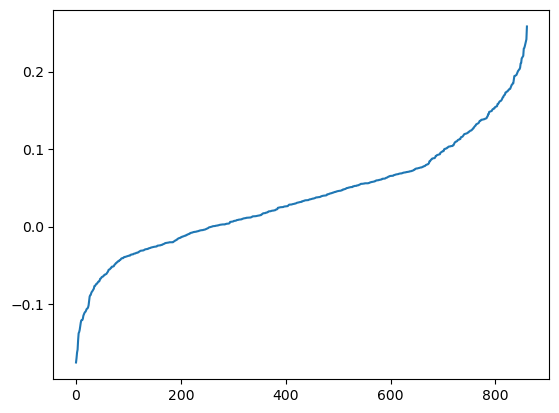

fit df.shape (206762, 882)
[861, 128]
[128, 128]
[128, 1]
Epoch 1/1000
36/36 - 4s - loss: 0.1051 - mse: 0.1051 - weighted_mse: 0.1051 - cosine_similarity: 0.0276 - val_loss: 0.1019 - val_mse: 0.1019 - val_weighted_mse: 0.1019 - val_cosine_similarity: 0.0094 - 4s/epoch - 121ms/step
Epoch 2/1000
36/36 - 2s - loss: 0.1049 - mse: 0.1049 - weighted_mse: 0.1049 - cosine_similarity: 0.0562 - val_loss: 0.1018 - val_mse: 0.1018 - val_weighted_mse: 0.1018 - val_cosine_similarity: 0.0215 - 2s/epoch - 44ms/step
Epoch 3/1000
36/36 - 2s - loss: 0.1045 - mse: 0.1045 - weighted_mse: 0.1045 - cosine_similarity: 0.0680 - val_loss: 0.1018 - val_mse: 0.1018 - val_weighted_mse: 0.1018 - val_cosine_similarity: 0.0270 - 2s/epoch - 45ms/step
Epoch 4/1000
36/36 - 2s - loss: 0.1041 - mse: 0.1041 - weighted_mse: 0.1041 - cosine_similarity: 0.0790 - val_loss: 0.1017 - val_mse: 0.1017 - val_weighted_mse: 0.1017 - val_cosine_similarity: 0.0361 - 2s/epoch - 49ms/step
Epoch 5/1000
36/36 - 2s - loss: 0.1037 - mse: 0.1

INFO:tensorflow:Assets written to: /tmp/tmpoejnwjci/assets
2022-10-21 16:28:56.008247: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:28:56.008337: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:28:56.008566: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpoejnwjci
2022-10-21 16:28:56.012083: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:28:56.012127: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpoejnwjci
2022-10-21 16:28:56.019806: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:28:56.114815: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpoejnwjci
2022-10-21 16:28:56.135784: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsstj91xz/assets


INFO:tensorflow:Assets written to: /tmp/tmpsstj91xz/assets
2022-10-21 16:28:58.651648: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:28:58.651737: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:28:58.652036: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsstj91xz
2022-10-21 16:28:58.654310: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:28:58.654347: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsstj91xz
2022-10-21 16:28:58.663458: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:28:58.781579: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsstj91xz
2022-10-21 16:28:58.800600: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8rsfukvb/assets


INFO:tensorflow:Assets written to: /tmp/tmp8rsfukvb/assets
2022-10-21 16:29:01.200130: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:29:01.200213: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:29:01.200452: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8rsfukvb
2022-10-21 16:29:01.203217: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:29:01.203267: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8rsfukvb
2022-10-21 16:29:01.211894: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:29:01.328515: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8rsfukvb
2022-10-21 16:29:01.351904: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp787z5rdl/assets


INFO:tensorflow:Assets written to: /tmp/tmp787z5rdl/assets
2022-10-21 16:29:03.711621: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:29:03.711718: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:29:03.712006: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp787z5rdl
2022-10-21 16:29:03.714310: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:29:03.714347: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp787z5rdl
2022-10-21 16:29:03.725934: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:29:03.824915: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp787z5rdl
2022-10-21 16:29:03.846870: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2h4dzpnm/assets


INFO:tensorflow:Assets written to: /tmp/tmp2h4dzpnm/assets
2022-10-21 16:29:06.232947: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:29:06.233035: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:29:06.233266: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2h4dzpnm
2022-10-21 16:29:06.235524: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:29:06.235560: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2h4dzpnm
2022-10-21 16:29:06.245501: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:29:06.336861: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2h4dzpnm
2022-10-21 16:29:06.356058: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5nmadmee/assets


INFO:tensorflow:Assets written to: /tmp/tmp5nmadmee/assets
2022-10-21 16:29:11.260130: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:29:11.260232: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:29:11.260546: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5nmadmee
2022-10-21 16:29:11.265996: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:29:11.266063: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5nmadmee
2022-10-21 16:29:11.281837: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:29:11.412893: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5nmadmee
2022-10-21 16:29:11.444117: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpf8je6n8y/assets


INFO:tensorflow:Assets written to: /tmp/tmpf8je6n8y/assets
2022-10-21 16:29:13.565758: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:29:13.565839: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:29:13.566052: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpf8je6n8y
2022-10-21 16:29:13.568415: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:29:13.568450: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpf8je6n8y
2022-10-21 16:29:13.576186: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:29:13.657985: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpf8je6n8y
2022-10-21 16:29:13.676543: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvhg4dchw/assets


INFO:tensorflow:Assets written to: /tmp/tmpvhg4dchw/assets
2022-10-21 16:29:15.591336: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:29:15.591421: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:29:15.591652: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvhg4dchw
2022-10-21 16:29:15.593863: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:29:15.593896: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvhg4dchw
2022-10-21 16:29:15.601132: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:29:15.682081: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvhg4dchw
2022-10-21 16:29:15.699469: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmps2qmiw__/assets


INFO:tensorflow:Assets written to: /tmp/tmps2qmiw__/assets
2022-10-21 16:29:17.511686: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:29:17.511765: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:29:17.511975: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps2qmiw__
2022-10-21 16:29:17.514166: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:29:17.514197: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps2qmiw__
2022-10-21 16:29:17.521264: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:29:17.594260: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmps2qmiw__
2022-10-21 16:29:17.611330: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmph6khnq2c/assets


INFO:tensorflow:Assets written to: /tmp/tmph6khnq2c/assets
2022-10-21 16:29:19.411863: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:29:19.411941: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:29:19.412142: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmph6khnq2c
2022-10-21 16:29:19.414064: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:29:19.414095: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmph6khnq2c
2022-10-21 16:29:19.420445: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:29:19.493418: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmph6khnq2c
2022-10-21 16:29:19.509269: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

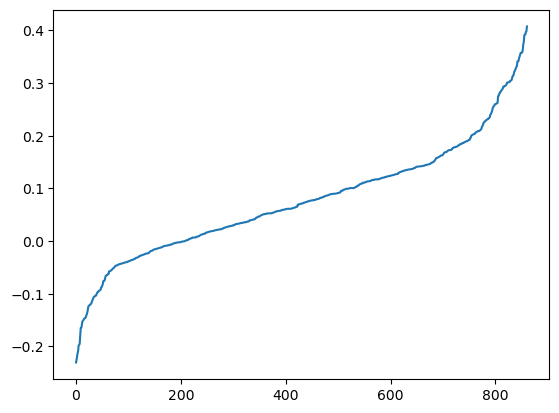

fit df.shape (199624, 882)
[861, 128]
[128, 128]
[128, 1]
Epoch 1/1000
35/35 - 3s - loss: 0.1063 - mse: 0.1063 - weighted_mse: 0.1063 - cosine_similarity: 0.0315 - val_loss: 0.1019 - val_mse: 0.1019 - val_weighted_mse: 0.1019 - val_cosine_similarity: 0.0072 - 3s/epoch - 90ms/step
Epoch 2/1000
35/35 - 1s - loss: 0.1060 - mse: 0.1060 - weighted_mse: 0.1060 - cosine_similarity: 0.0606 - val_loss: 0.1019 - val_mse: 0.1019 - val_weighted_mse: 0.1019 - val_cosine_similarity: 0.0130 - 1s/epoch - 36ms/step
Epoch 3/1000
35/35 - 1s - loss: 0.1056 - mse: 0.1056 - weighted_mse: 0.1056 - cosine_similarity: 0.0705 - val_loss: 0.1018 - val_mse: 0.1018 - val_weighted_mse: 0.1018 - val_cosine_similarity: 0.0167 - 1s/epoch - 41ms/step
Epoch 4/1000
35/35 - 1s - loss: 0.1052 - mse: 0.1052 - weighted_mse: 0.1052 - cosine_similarity: 0.0772 - val_loss: 0.1017 - val_mse: 0.1017 - val_weighted_mse: 0.1017 - val_cosine_similarity: 0.0236 - 1s/epoch - 35ms/step
Epoch 5/1000
35/35 - 2s - loss: 0.1047 - mse: 0.10

INFO:tensorflow:Assets written to: /tmp/tmpcb6n3if5/assets
2022-10-21 16:37:53.125512: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:37:53.125598: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:37:53.125820: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcb6n3if5
2022-10-21 16:37:53.128013: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:37:53.128050: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcb6n3if5
2022-10-21 16:37:53.135538: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:37:53.217232: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcb6n3if5
2022-10-21 16:37:53.233962: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkhsj7tus/assets


INFO:tensorflow:Assets written to: /tmp/tmpkhsj7tus/assets
2022-10-21 16:37:55.303653: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:37:55.303736: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:37:55.303977: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkhsj7tus
2022-10-21 16:37:55.306078: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:37:55.306113: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkhsj7tus
2022-10-21 16:37:55.314262: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:37:55.401563: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkhsj7tus
2022-10-21 16:37:55.422232: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1sawbplk/assets


INFO:tensorflow:Assets written to: /tmp/tmp1sawbplk/assets
2022-10-21 16:37:57.617257: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:37:57.617328: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:37:57.617537: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1sawbplk
2022-10-21 16:37:57.619679: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:37:57.619711: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1sawbplk
2022-10-21 16:37:57.626613: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:37:57.700121: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1sawbplk
2022-10-21 16:37:57.725138: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm5u5n2y9/assets


INFO:tensorflow:Assets written to: /tmp/tmpm5u5n2y9/assets
2022-10-21 16:37:59.766348: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:37:59.766445: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:37:59.766673: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm5u5n2y9
2022-10-21 16:37:59.768937: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:37:59.768973: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm5u5n2y9
2022-10-21 16:37:59.776777: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:37:59.854719: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm5u5n2y9
2022-10-21 16:37:59.872542: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzofj2ey4/assets


INFO:tensorflow:Assets written to: /tmp/tmpzofj2ey4/assets
2022-10-21 16:38:01.931717: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:38:01.931801: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:38:01.932015: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzofj2ey4
2022-10-21 16:38:01.934007: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:38:01.934039: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzofj2ey4
2022-10-21 16:38:01.940767: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:38:02.013583: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzofj2ey4
2022-10-21 16:38:02.030264: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbeylfa_w/assets


INFO:tensorflow:Assets written to: /tmp/tmpbeylfa_w/assets
2022-10-21 16:38:03.771052: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:38:03.771140: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:38:03.771395: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbeylfa_w
2022-10-21 16:38:03.773225: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:38:03.773255: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbeylfa_w
2022-10-21 16:38:03.780871: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:38:03.852702: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbeylfa_w
2022-10-21 16:38:03.868561: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm8eog0xv/assets


INFO:tensorflow:Assets written to: /tmp/tmpm8eog0xv/assets
2022-10-21 16:38:05.528066: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:38:05.528150: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:38:05.528387: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm8eog0xv
2022-10-21 16:38:05.530141: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:38:05.530170: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm8eog0xv
2022-10-21 16:38:05.536603: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:38:05.604928: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm8eog0xv
2022-10-21 16:38:05.620276: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmps9khguok/assets


INFO:tensorflow:Assets written to: /tmp/tmps9khguok/assets
2022-10-21 16:38:07.151118: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:38:07.151193: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:38:07.151424: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps9khguok
2022-10-21 16:38:07.153104: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:38:07.153131: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps9khguok
2022-10-21 16:38:07.159317: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:38:07.222387: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmps9khguok
2022-10-21 16:38:07.235974: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp930tjqjr/assets


INFO:tensorflow:Assets written to: /tmp/tmp930tjqjr/assets
2022-10-21 16:38:08.703297: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:38:08.703400: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:38:08.703577: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp930tjqjr
2022-10-21 16:38:08.705264: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:38:08.705297: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp930tjqjr
2022-10-21 16:38:08.710786: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:38:08.777670: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp930tjqjr
2022-10-21 16:38:08.791445: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplpu9ckbe/assets


INFO:tensorflow:Assets written to: /tmp/tmplpu9ckbe/assets
2022-10-21 16:38:10.185796: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:38:10.185847: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:38:10.186005: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplpu9ckbe
2022-10-21 16:38:10.187618: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:38:10.187643: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplpu9ckbe
2022-10-21 16:38:10.194088: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:38:10.250522: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplpu9ckbe
2022-10-21 16:38:10.262987: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

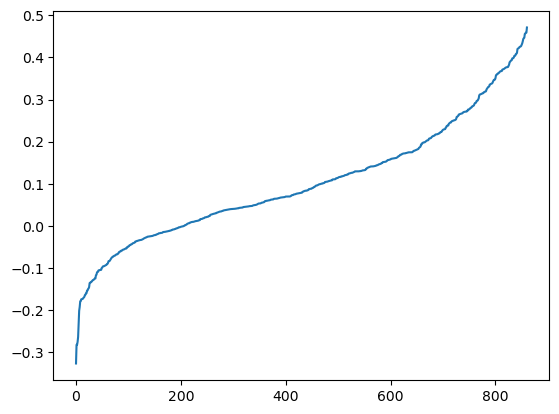

fit df.shape (199624, 882)
[861, 128]
[128, 128]
[128, 1]
Epoch 1/1000
35/35 - 3s - loss: 0.1064 - mse: 0.1064 - weighted_mse: 0.1064 - cosine_similarity: 0.0182 - val_loss: 0.1019 - val_mse: 0.1019 - val_weighted_mse: 0.1019 - val_cosine_similarity: 0.0110 - 3s/epoch - 80ms/step
Epoch 2/1000
35/35 - 1s - loss: 0.1061 - mse: 0.1061 - weighted_mse: 0.1061 - cosine_similarity: 0.0485 - val_loss: 0.1018 - val_mse: 0.1018 - val_weighted_mse: 0.1018 - val_cosine_similarity: 0.0229 - 1s/epoch - 31ms/step
Epoch 3/1000
35/35 - 1s - loss: 0.1057 - mse: 0.1057 - weighted_mse: 0.1057 - cosine_similarity: 0.0644 - val_loss: 0.1018 - val_mse: 0.1018 - val_weighted_mse: 0.1018 - val_cosine_similarity: 0.0265 - 1s/epoch - 41ms/step
Epoch 4/1000
35/35 - 2s - loss: 0.1053 - mse: 0.1053 - weighted_mse: 0.1053 - cosine_similarity: 0.0768 - val_loss: 0.1017 - val_mse: 0.1017 - val_weighted_mse: 0.1017 - val_cosine_similarity: 0.0339 - 2s/epoch - 50ms/step
Epoch 5/1000
35/35 - 2s - loss: 0.1049 - mse: 0.10

INFO:tensorflow:Assets written to: /tmp/tmpom8699eh/assets
2022-10-21 16:44:58.174327: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:44:58.174408: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:44:58.174667: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpom8699eh
2022-10-21 16:44:58.176658: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:44:58.176689: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpom8699eh
2022-10-21 16:44:58.183918: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:44:58.261484: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpom8699eh
2022-10-21 16:44:58.279065: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsrdr04b8/assets


INFO:tensorflow:Assets written to: /tmp/tmpsrdr04b8/assets
2022-10-21 16:45:00.096931: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:45:00.097044: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:45:00.097255: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsrdr04b8
2022-10-21 16:45:00.099390: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:45:00.099431: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsrdr04b8
2022-10-21 16:45:00.107413: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:45:00.187024: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsrdr04b8
2022-10-21 16:45:00.205505: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpygy7qlxl/assets


INFO:tensorflow:Assets written to: /tmp/tmpygy7qlxl/assets
2022-10-21 16:45:02.108710: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:45:02.108785: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:45:02.108977: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpygy7qlxl
2022-10-21 16:45:02.110786: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:45:02.110814: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpygy7qlxl
2022-10-21 16:45:02.116825: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:45:02.199206: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpygy7qlxl
2022-10-21 16:45:02.220362: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpuglfpld0/assets


INFO:tensorflow:Assets written to: /tmp/tmpuglfpld0/assets
2022-10-21 16:45:03.934952: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:45:03.935024: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:45:03.935250: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuglfpld0
2022-10-21 16:45:03.936915: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:45:03.936941: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuglfpld0
2022-10-21 16:45:03.942506: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:45:04.009350: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuglfpld0
2022-10-21 16:45:04.022858: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqaokv5g0/assets


INFO:tensorflow:Assets written to: /tmp/tmpqaokv5g0/assets
2022-10-21 16:45:05.593930: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:45:05.593999: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:45:05.594225: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqaokv5g0
2022-10-21 16:45:05.595833: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:45:05.595859: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqaokv5g0
2022-10-21 16:45:05.601370: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:45:05.662168: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqaokv5g0
2022-10-21 16:45:05.675899: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpa2mdojby/assets


INFO:tensorflow:Assets written to: /tmp/tmpa2mdojby/assets
2022-10-21 16:45:07.133193: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:45:07.133277: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:45:07.133536: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa2mdojby
2022-10-21 16:45:07.135179: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:45:07.135208: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa2mdojby
2022-10-21 16:45:07.140399: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:45:07.200955: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpa2mdojby
2022-10-21 16:45:07.214334: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpc6e2m9q7/assets


INFO:tensorflow:Assets written to: /tmp/tmpc6e2m9q7/assets
2022-10-21 16:45:08.740654: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:45:08.740723: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:45:08.740921: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpc6e2m9q7
2022-10-21 16:45:08.743635: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:45:08.743703: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpc6e2m9q7
2022-10-21 16:45:08.751221: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:45:08.819723: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpc6e2m9q7
2022-10-21 16:45:08.835131: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwz7jmpzi/assets


INFO:tensorflow:Assets written to: /tmp/tmpwz7jmpzi/assets
2022-10-21 16:45:10.425070: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:45:10.425157: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:45:10.425321: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwz7jmpzi
2022-10-21 16:45:10.426830: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:45:10.426855: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwz7jmpzi
2022-10-21 16:45:10.432621: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:45:10.493153: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwz7jmpzi
2022-10-21 16:45:10.505608: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpv__z1yww/assets


INFO:tensorflow:Assets written to: /tmp/tmpv__z1yww/assets
2022-10-21 16:45:11.991474: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:45:11.991545: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:45:11.991747: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpv__z1yww
2022-10-21 16:45:11.993249: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:45:11.993273: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpv__z1yww
2022-10-21 16:45:11.999264: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:45:12.061256: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpv__z1yww
2022-10-21 16:45:12.073828: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1hp15ndu/assets


INFO:tensorflow:Assets written to: /tmp/tmp1hp15ndu/assets
2022-10-21 16:45:13.649360: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:45:13.649437: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:45:13.649661: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1hp15ndu
2022-10-21 16:45:13.651465: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:45:13.651494: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1hp15ndu
2022-10-21 16:45:13.658334: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:45:13.725842: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1hp15ndu
2022-10-21 16:45:13.740093: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

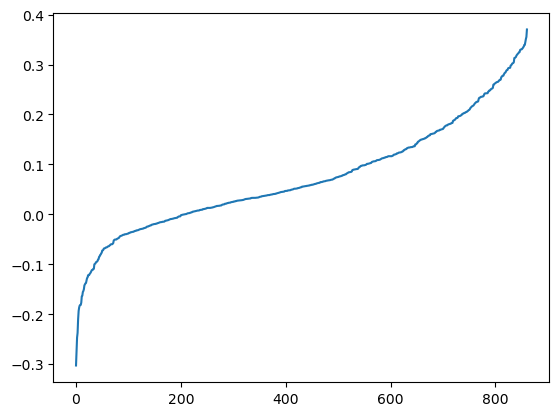

fit df.shape (200128, 882)
[861, 128]
[128, 128]
[128, 1]
Epoch 1/1000
35/35 - 5s - loss: 0.1063 - mse: 0.1063 - weighted_mse: 0.1063 - cosine_similarity: 0.0184 - val_loss: 0.1017 - val_mse: 0.1017 - val_weighted_mse: 0.1017 - val_cosine_similarity: 0.0521 - 5s/epoch - 133ms/step
Epoch 2/1000
35/35 - 1s - loss: 0.1061 - mse: 0.1061 - weighted_mse: 0.1061 - cosine_similarity: 0.0489 - val_loss: 0.1016 - val_mse: 0.1016 - val_weighted_mse: 0.1016 - val_cosine_similarity: 0.0733 - 1s/epoch - 42ms/step
Epoch 3/1000
35/35 - 1s - loss: 0.1057 - mse: 0.1057 - weighted_mse: 0.1057 - cosine_similarity: 0.0658 - val_loss: 0.1014 - val_mse: 0.1014 - val_weighted_mse: 0.1014 - val_cosine_similarity: 0.0773 - 1s/epoch - 41ms/step
Epoch 4/1000
35/35 - 1s - loss: 0.1053 - mse: 0.1053 - weighted_mse: 0.1053 - cosine_similarity: 0.0783 - val_loss: 0.1013 - val_mse: 0.1013 - val_weighted_mse: 0.1013 - val_cosine_similarity: 0.0836 - 1s/epoch - 33ms/step
Epoch 5/1000
35/35 - 1s - loss: 0.1049 - mse: 0.1

INFO:tensorflow:Assets written to: /tmp/tmpn_z3wfsd/assets
2022-10-21 16:53:57.451761: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:53:57.451834: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:53:57.452021: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpn_z3wfsd
2022-10-21 16:53:57.453726: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:53:57.453753: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpn_z3wfsd
2022-10-21 16:53:57.459726: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:53:57.548921: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpn_z3wfsd
2022-10-21 16:53:57.565697: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp80am75d2/assets


INFO:tensorflow:Assets written to: /tmp/tmp80am75d2/assets
2022-10-21 16:53:59.435479: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:53:59.435579: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:53:59.435766: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp80am75d2
2022-10-21 16:53:59.437440: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:53:59.437467: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp80am75d2
2022-10-21 16:53:59.443122: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:53:59.511806: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp80am75d2
2022-10-21 16:53:59.531123: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7bp10or5/assets


INFO:tensorflow:Assets written to: /tmp/tmp7bp10or5/assets
2022-10-21 16:54:01.081517: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:54:01.081581: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:54:01.081750: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7bp10or5
2022-10-21 16:54:01.083325: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:54:01.083351: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7bp10or5
2022-10-21 16:54:01.088578: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:54:01.152388: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7bp10or5
2022-10-21 16:54:01.165765: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6uphcia1/assets


INFO:tensorflow:Assets written to: /tmp/tmp6uphcia1/assets
2022-10-21 16:54:02.762200: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:54:02.762408: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:54:02.762783: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6uphcia1
2022-10-21 16:54:02.764749: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:54:02.764783: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6uphcia1
2022-10-21 16:54:02.771209: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:54:02.831940: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6uphcia1
2022-10-21 16:54:02.846752: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1xk0ksk5/assets


INFO:tensorflow:Assets written to: /tmp/tmp1xk0ksk5/assets
2022-10-21 16:54:04.385090: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:54:04.385165: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:54:04.385372: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1xk0ksk5
2022-10-21 16:54:04.387239: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:54:04.387271: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1xk0ksk5
2022-10-21 16:54:04.392827: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:54:04.461984: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1xk0ksk5
2022-10-21 16:54:04.477735: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpouw5ut79/assets


INFO:tensorflow:Assets written to: /tmp/tmpouw5ut79/assets
2022-10-21 16:54:06.146458: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:54:06.146521: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:54:06.146927: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpouw5ut79
2022-10-21 16:54:06.149349: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:54:06.149441: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpouw5ut79
2022-10-21 16:54:06.156183: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:54:06.230362: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpouw5ut79
2022-10-21 16:54:06.248797: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6_ki1p1g/assets


INFO:tensorflow:Assets written to: /tmp/tmp6_ki1p1g/assets
2022-10-21 16:54:07.919045: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:54:07.919118: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:54:07.919295: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6_ki1p1g
2022-10-21 16:54:07.920952: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:54:07.920982: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6_ki1p1g
2022-10-21 16:54:07.926378: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:54:08.003797: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6_ki1p1g
2022-10-21 16:54:08.020788: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprp6c2bk8/assets


INFO:tensorflow:Assets written to: /tmp/tmprp6c2bk8/assets
2022-10-21 16:54:09.577868: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:54:09.577933: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:54:09.578096: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprp6c2bk8
2022-10-21 16:54:09.579641: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:54:09.579666: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmprp6c2bk8
2022-10-21 16:54:09.585139: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:54:09.643318: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmprp6c2bk8
2022-10-21 16:54:09.656914: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnqvb5trm/assets


INFO:tensorflow:Assets written to: /tmp/tmpnqvb5trm/assets
2022-10-21 16:54:11.296958: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:54:11.297023: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:54:11.297186: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnqvb5trm
2022-10-21 16:54:11.298675: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:54:11.298727: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnqvb5trm
2022-10-21 16:54:11.303669: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:54:11.360960: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnqvb5trm
2022-10-21 16:54:11.373162: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqgy01ly4/assets


INFO:tensorflow:Assets written to: /tmp/tmpqgy01ly4/assets
2022-10-21 16:54:12.868597: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 16:54:12.868797: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 16:54:12.869249: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqgy01ly4
2022-10-21 16:54:12.871175: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 16:54:12.871214: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqgy01ly4
2022-10-21 16:54:12.877667: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 16:54:12.940604: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqgy01ly4
2022-10-21 16:54:12.953744: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

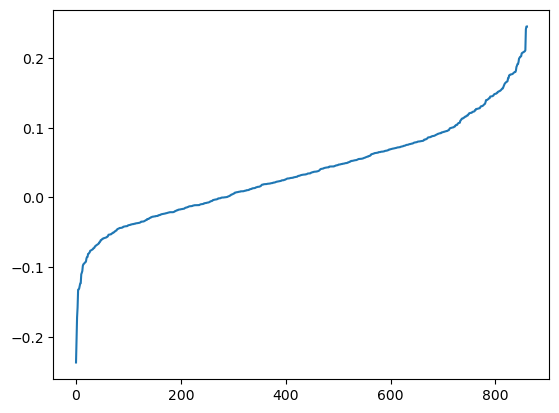

return without cost statistics
mean 0.002823406550314656
std 0.016615838600796275
sharpe 0.16992260325514663
double sharpe 1.164715346933044
max drawdown 0.24390139090571694
return with cost statistics
mean 0.0017503804581053255
std 0.0166307530598426
sharpe 0.105249621096947
double sharpe 0.5848436600653569
max drawdown 0.24459212294803767


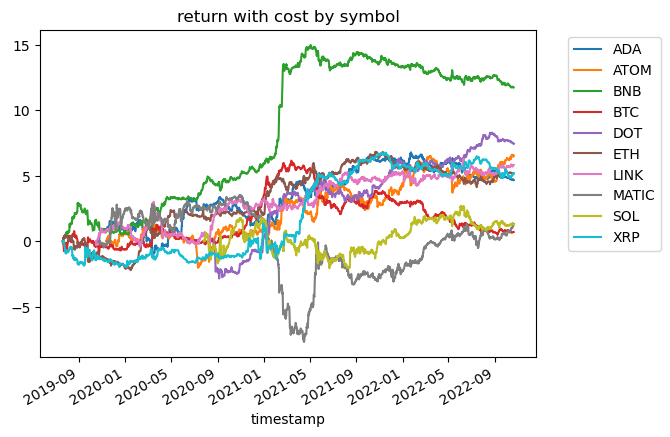

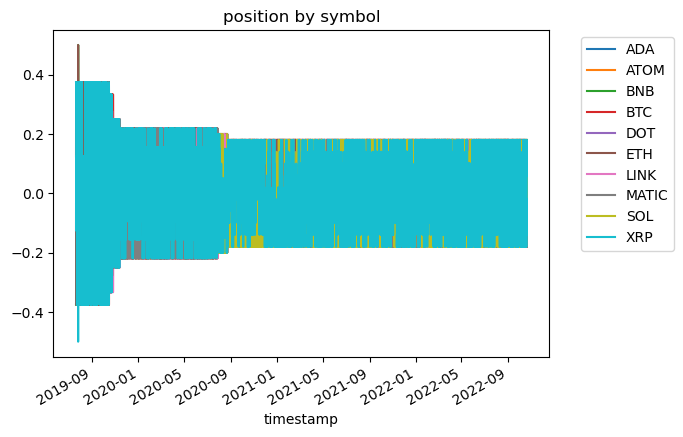

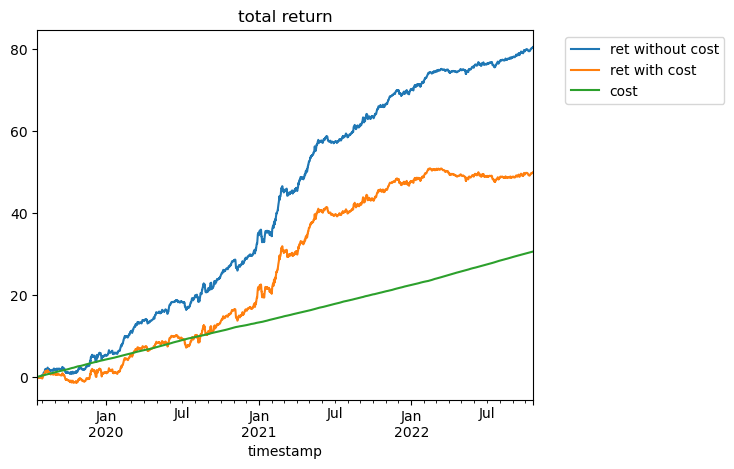

fit df.shape (257204, 882)
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[128, 128]
[128, 1]
[861, 128]
[

INFO:tensorflow:Assets written to: /tmp/tmplg5zpfzm/assets
2022-10-21 18:07:17.250541: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:17.250629: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:17.250843: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplg5zpfzm
2022-10-21 18:07:17.252942: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:17.252975: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplg5zpfzm
2022-10-21 18:07:17.261980: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:17.345695: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplg5zpfzm
2022-10-21 18:07:17.361567: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm2z6n4l7/assets


INFO:tensorflow:Assets written to: /tmp/tmpm2z6n4l7/assets
2022-10-21 18:07:19.129207: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:19.129268: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:19.129456: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm2z6n4l7
2022-10-21 18:07:19.131414: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:19.131444: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm2z6n4l7
2022-10-21 18:07:19.139230: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:19.215826: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm2z6n4l7
2022-10-21 18:07:19.231039: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyk0k0tt7/assets


INFO:tensorflow:Assets written to: /tmp/tmpyk0k0tt7/assets
2022-10-21 18:07:20.868970: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:20.869031: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:20.869214: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyk0k0tt7
2022-10-21 18:07:20.871100: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:20.871130: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyk0k0tt7
2022-10-21 18:07:20.880634: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:20.948583: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyk0k0tt7
2022-10-21 18:07:20.963184: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbd8fl4uv/assets


INFO:tensorflow:Assets written to: /tmp/tmpbd8fl4uv/assets
2022-10-21 18:07:22.507932: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:22.508004: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:22.508203: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbd8fl4uv
2022-10-21 18:07:22.510008: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:22.510037: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbd8fl4uv
2022-10-21 18:07:22.516998: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:22.578485: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbd8fl4uv
2022-10-21 18:07:22.591905: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzlqbggmv/assets


INFO:tensorflow:Assets written to: /tmp/tmpzlqbggmv/assets
2022-10-21 18:07:24.069181: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:24.069251: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:24.069426: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzlqbggmv
2022-10-21 18:07:24.071186: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:24.071214: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzlqbggmv
2022-10-21 18:07:24.078023: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:24.141218: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzlqbggmv
2022-10-21 18:07:24.153745: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmprih59f2l/assets


INFO:tensorflow:Assets written to: /tmp/tmprih59f2l/assets
2022-10-21 18:07:25.591378: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:25.591447: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:25.591653: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmprih59f2l
2022-10-21 18:07:25.593294: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:25.593320: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmprih59f2l
2022-10-21 18:07:25.600025: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:25.660206: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmprih59f2l
2022-10-21 18:07:25.672378: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpfslb5b4w/assets


INFO:tensorflow:Assets written to: /tmp/tmpfslb5b4w/assets
2022-10-21 18:07:27.029999: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:27.030062: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:27.030225: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpfslb5b4w
2022-10-21 18:07:27.031808: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:27.031832: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpfslb5b4w
2022-10-21 18:07:27.038185: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:27.091715: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpfslb5b4w
2022-10-21 18:07:27.103535: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdldxx7g8/assets


INFO:tensorflow:Assets written to: /tmp/tmpdldxx7g8/assets
2022-10-21 18:07:28.395541: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:28.395603: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:28.395790: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdldxx7g8
2022-10-21 18:07:28.397289: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:28.397314: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdldxx7g8
2022-10-21 18:07:28.403248: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:28.461430: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdldxx7g8
2022-10-21 18:07:28.475116: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpubw2q0l_/assets


INFO:tensorflow:Assets written to: /tmp/tmpubw2q0l_/assets
2022-10-21 18:07:29.708718: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:29.708786: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:29.708946: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpubw2q0l_
2022-10-21 18:07:29.710409: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:29.710433: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpubw2q0l_
2022-10-21 18:07:29.716247: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:29.766812: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpubw2q0l_
2022-10-21 18:07:29.778307: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmvm_jnh6/assets


INFO:tensorflow:Assets written to: /tmp/tmpmvm_jnh6/assets
2022-10-21 18:07:30.990148: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:30.990208: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:30.990397: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmvm_jnh6
2022-10-21 18:07:30.991848: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:30.991872: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmvm_jnh6
2022-10-21 18:07:30.997523: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:31.047586: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmvm_jnh6
2022-10-21 18:07:31.059154: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwwsau61e/assets


INFO:tensorflow:Assets written to: /tmp/tmpwwsau61e/assets
2022-10-21 18:07:35.780811: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:35.780870: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:35.781023: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwwsau61e
2022-10-21 18:07:35.783211: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:35.783234: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwwsau61e
2022-10-21 18:07:35.791371: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:35.856695: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwwsau61e
2022-10-21 18:07:35.872648: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2n8p1bql/assets


INFO:tensorflow:Assets written to: /tmp/tmp2n8p1bql/assets
2022-10-21 18:07:37.086368: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:37.086427: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:37.086574: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2n8p1bql
2022-10-21 18:07:37.088211: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:37.088235: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2n8p1bql
2022-10-21 18:07:37.094476: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:37.147993: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2n8p1bql
2022-10-21 18:07:37.160276: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpiisnlvck/assets


INFO:tensorflow:Assets written to: /tmp/tmpiisnlvck/assets
2022-10-21 18:07:38.311512: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:38.311571: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:38.311715: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpiisnlvck
2022-10-21 18:07:38.313201: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:38.313224: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpiisnlvck
2022-10-21 18:07:38.318397: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:38.368385: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpiisnlvck
2022-10-21 18:07:38.380337: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpe30iweus/assets


INFO:tensorflow:Assets written to: /tmp/tmpe30iweus/assets
2022-10-21 18:07:39.536253: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:39.536312: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:39.536460: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpe30iweus
2022-10-21 18:07:39.537861: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:39.537883: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpe30iweus
2022-10-21 18:07:39.542676: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:39.593021: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpe30iweus
2022-10-21 18:07:39.604333: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphpcopzj8/assets


INFO:tensorflow:Assets written to: /tmp/tmphpcopzj8/assets
2022-10-21 18:07:40.733604: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:40.733680: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:40.733823: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphpcopzj8
2022-10-21 18:07:40.735164: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:40.735186: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphpcopzj8
2022-10-21 18:07:40.739740: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:40.787489: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphpcopzj8
2022-10-21 18:07:40.799036: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmptltdpaxb/assets


INFO:tensorflow:Assets written to: /tmp/tmptltdpaxb/assets
2022-10-21 18:07:41.912159: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:41.912218: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:41.912394: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptltdpaxb
2022-10-21 18:07:41.913684: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:41.913706: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptltdpaxb
2022-10-21 18:07:41.918220: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:41.966428: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmptltdpaxb
2022-10-21 18:07:41.977277: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3_w4800o/assets


INFO:tensorflow:Assets written to: /tmp/tmp3_w4800o/assets
2022-10-21 18:07:43.097441: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:43.097499: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:43.097644: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3_w4800o
2022-10-21 18:07:43.098960: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:43.098982: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3_w4800o
2022-10-21 18:07:43.103395: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:43.150713: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3_w4800o
2022-10-21 18:07:43.161265: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1pl8k3je/assets


INFO:tensorflow:Assets written to: /tmp/tmp1pl8k3je/assets
2022-10-21 18:07:44.292391: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:44.292447: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:44.292623: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1pl8k3je
2022-10-21 18:07:44.293902: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:44.293922: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1pl8k3je
2022-10-21 18:07:44.298156: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:44.344572: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1pl8k3je
2022-10-21 18:07:44.355131: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphdqfcy87/assets


INFO:tensorflow:Assets written to: /tmp/tmphdqfcy87/assets
2022-10-21 18:07:45.467922: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:45.467979: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:45.468127: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphdqfcy87
2022-10-21 18:07:45.469406: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:45.469429: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphdqfcy87
2022-10-21 18:07:45.473711: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:45.519646: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphdqfcy87
2022-10-21 18:07:45.530183: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxaxva550/assets


INFO:tensorflow:Assets written to: /tmp/tmpxaxva550/assets
2022-10-21 18:07:46.635344: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:46.635406: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:46.635554: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxaxva550
2022-10-21 18:07:46.636895: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:46.636918: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxaxva550
2022-10-21 18:07:46.641271: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:46.687290: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxaxva550
2022-10-21 18:07:46.697910: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpe6kmqyzd/assets


INFO:tensorflow:Assets written to: /tmp/tmpe6kmqyzd/assets
2022-10-21 18:07:47.808112: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:47.808169: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:47.808312: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpe6kmqyzd
2022-10-21 18:07:47.809619: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:47.809640: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpe6kmqyzd
2022-10-21 18:07:47.813862: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:47.859553: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpe6kmqyzd
2022-10-21 18:07:47.870027: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpk6nx17mc/assets


INFO:tensorflow:Assets written to: /tmp/tmpk6nx17mc/assets
2022-10-21 18:07:48.955792: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:48.955848: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:48.956025: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpk6nx17mc
2022-10-21 18:07:48.957254: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:48.957275: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpk6nx17mc
2022-10-21 18:07:48.961531: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:49.007193: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpk6nx17mc
2022-10-21 18:07:49.017338: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpsofahm8s/assets


INFO:tensorflow:Assets written to: /tmp/tmpsofahm8s/assets
2022-10-21 18:07:50.121715: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:50.121772: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:50.121948: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpsofahm8s
2022-10-21 18:07:50.123184: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:50.123203: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpsofahm8s
2022-10-21 18:07:50.127473: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:50.174577: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpsofahm8s
2022-10-21 18:07:50.185331: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpr6ok2iq4/assets


INFO:tensorflow:Assets written to: /tmp/tmpr6ok2iq4/assets
2022-10-21 18:07:51.281619: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:51.281675: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:51.281817: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpr6ok2iq4
2022-10-21 18:07:51.283069: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:51.283089: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpr6ok2iq4
2022-10-21 18:07:51.287251: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:51.334875: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpr6ok2iq4
2022-10-21 18:07:51.344998: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpe_tb6_63/assets


INFO:tensorflow:Assets written to: /tmp/tmpe_tb6_63/assets
2022-10-21 18:07:52.448563: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:52.448618: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:52.448761: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpe_tb6_63
2022-10-21 18:07:52.450029: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:52.450051: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpe_tb6_63
2022-10-21 18:07:52.454250: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:52.504670: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpe_tb6_63
2022-10-21 18:07:52.514929: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzdnhi5lb/assets


INFO:tensorflow:Assets written to: /tmp/tmpzdnhi5lb/assets
2022-10-21 18:07:53.619057: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:53.619221: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:53.619379: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzdnhi5lb
2022-10-21 18:07:53.620702: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:53.620725: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzdnhi5lb
2022-10-21 18:07:53.625281: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:53.674819: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzdnhi5lb
2022-10-21 18:07:53.685421: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpceuvlih8/assets


INFO:tensorflow:Assets written to: /tmp/tmpceuvlih8/assets
2022-10-21 18:07:54.787717: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:54.787772: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:54.787916: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpceuvlih8
2022-10-21 18:07:54.789182: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:54.789203: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpceuvlih8
2022-10-21 18:07:54.793402: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:54.843319: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpceuvlih8
2022-10-21 18:07:54.853592: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp78zydon5/assets


INFO:tensorflow:Assets written to: /tmp/tmp78zydon5/assets
2022-10-21 18:07:55.944715: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:55.944764: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:55.944985: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp78zydon5
2022-10-21 18:07:55.946377: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:55.946395: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp78zydon5
2022-10-21 18:07:55.950110: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:55.991295: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp78zydon5
2022-10-21 18:07:56.000916: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyrsl2uzr/assets


INFO:tensorflow:Assets written to: /tmp/tmpyrsl2uzr/assets
2022-10-21 18:07:57.037995: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:57.038045: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:57.038196: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyrsl2uzr
2022-10-21 18:07:57.039396: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:57.039415: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyrsl2uzr
2022-10-21 18:07:57.044509: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:57.094665: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyrsl2uzr
2022-10-21 18:07:57.104638: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqo21o9k2/assets


INFO:tensorflow:Assets written to: /tmp/tmpqo21o9k2/assets
2022-10-21 18:07:58.118869: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:58.118916: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:58.119039: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqo21o9k2
2022-10-21 18:07:58.120376: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:58.120395: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqo21o9k2
2022-10-21 18:07:58.125833: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:58.179583: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqo21o9k2
2022-10-21 18:07:58.190156: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpc35dh3_4/assets


INFO:tensorflow:Assets written to: /tmp/tmpc35dh3_4/assets
2022-10-21 18:07:59.217389: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:07:59.217439: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:07:59.217571: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpc35dh3_4
2022-10-21 18:07:59.218829: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:07:59.218847: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpc35dh3_4
2022-10-21 18:07:59.223784: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:07:59.264842: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpc35dh3_4
2022-10-21 18:07:59.273608: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxsg6ijcz/assets


INFO:tensorflow:Assets written to: /tmp/tmpxsg6ijcz/assets
2022-10-21 18:08:00.296172: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:00.296219: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:00.296343: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxsg6ijcz
2022-10-21 18:08:00.297643: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:00.297662: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxsg6ijcz
2022-10-21 18:08:00.302502: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:00.343260: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxsg6ijcz
2022-10-21 18:08:00.352367: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9h01vlc8/assets


INFO:tensorflow:Assets written to: /tmp/tmp9h01vlc8/assets
2022-10-21 18:08:01.384588: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:01.384641: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:01.384774: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9h01vlc8
2022-10-21 18:08:01.386053: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:01.386074: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9h01vlc8
2022-10-21 18:08:01.391565: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:01.436395: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9h01vlc8
2022-10-21 18:08:01.445358: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxrijcn7j/assets


INFO:tensorflow:Assets written to: /tmp/tmpxrijcn7j/assets
2022-10-21 18:08:02.476669: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:02.476723: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:02.476962: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxrijcn7j
2022-10-21 18:08:02.478425: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:02.478444: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxrijcn7j
2022-10-21 18:08:02.484590: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:02.528813: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxrijcn7j
2022-10-21 18:08:02.538332: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcoeb5e6q/assets


INFO:tensorflow:Assets written to: /tmp/tmpcoeb5e6q/assets
2022-10-21 18:08:03.558371: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:03.558418: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:03.558624: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcoeb5e6q
2022-10-21 18:08:03.559817: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:03.559835: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcoeb5e6q
2022-10-21 18:08:03.564787: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:03.607865: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcoeb5e6q
2022-10-21 18:08:03.617045: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1g0_5m2n/assets


INFO:tensorflow:Assets written to: /tmp/tmp1g0_5m2n/assets
2022-10-21 18:08:04.628439: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:04.628491: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:04.628617: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1g0_5m2n
2022-10-21 18:08:04.629813: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:04.629833: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1g0_5m2n
2022-10-21 18:08:04.635030: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:04.683057: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1g0_5m2n
2022-10-21 18:08:04.693545: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbpby9j_6/assets


INFO:tensorflow:Assets written to: /tmp/tmpbpby9j_6/assets
2022-10-21 18:08:08.579365: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:08.579425: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:08.579583: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbpby9j_6
2022-10-21 18:08:08.581890: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:08.581916: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbpby9j_6
2022-10-21 18:08:08.590530: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:08.660796: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbpby9j_6
2022-10-21 18:08:08.686295: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnxwxz31m/assets


INFO:tensorflow:Assets written to: /tmp/tmpnxwxz31m/assets
2022-10-21 18:08:09.853767: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:09.853832: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:09.854015: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnxwxz31m
2022-10-21 18:08:09.855723: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:09.855746: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnxwxz31m
2022-10-21 18:08:09.862127: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:09.918374: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnxwxz31m
2022-10-21 18:08:09.931530: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplmtwqzst/assets


INFO:tensorflow:Assets written to: /tmp/tmplmtwqzst/assets
2022-10-21 18:08:11.012161: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:11.012212: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:11.012344: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplmtwqzst
2022-10-21 18:08:11.013760: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:11.013781: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplmtwqzst
2022-10-21 18:08:11.019302: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:11.068492: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplmtwqzst
2022-10-21 18:08:11.079457: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpldt8hn7c/assets


INFO:tensorflow:Assets written to: /tmp/tmpldt8hn7c/assets
2022-10-21 18:08:12.148878: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:12.148934: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:12.149077: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpldt8hn7c
2022-10-21 18:08:12.150551: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:12.150573: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpldt8hn7c
2022-10-21 18:08:12.155707: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:12.211354: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpldt8hn7c
2022-10-21 18:08:12.223109: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwta8eca8/assets


INFO:tensorflow:Assets written to: /tmp/tmpwta8eca8/assets
2022-10-21 18:08:13.277055: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:13.277139: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:13.277290: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwta8eca8
2022-10-21 18:08:13.278758: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:13.278782: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwta8eca8
2022-10-21 18:08:13.283813: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:13.338795: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwta8eca8
2022-10-21 18:08:13.350350: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyeyg29t2/assets


INFO:tensorflow:Assets written to: /tmp/tmpyeyg29t2/assets
2022-10-21 18:08:14.394720: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:14.394771: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:14.394918: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyeyg29t2
2022-10-21 18:08:14.396171: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:14.396191: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyeyg29t2
2022-10-21 18:08:14.400443: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:14.446793: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyeyg29t2
2022-10-21 18:08:14.456497: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpx0slzryj/assets


INFO:tensorflow:Assets written to: /tmp/tmpx0slzryj/assets
2022-10-21 18:08:15.479658: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:15.479717: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:15.479861: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpx0slzryj
2022-10-21 18:08:15.481241: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:15.481264: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpx0slzryj
2022-10-21 18:08:15.485933: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:15.532927: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpx0slzryj
2022-10-21 18:08:15.542758: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppy63hc2m/assets


INFO:tensorflow:Assets written to: /tmp/tmppy63hc2m/assets
2022-10-21 18:08:16.563905: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:16.563954: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:16.564098: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppy63hc2m
2022-10-21 18:08:16.565190: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:16.565209: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppy63hc2m
2022-10-21 18:08:16.569319: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:16.612739: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppy63hc2m
2022-10-21 18:08:16.622064: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6mtoyvmi/assets


INFO:tensorflow:Assets written to: /tmp/tmp6mtoyvmi/assets
2022-10-21 18:08:17.698711: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:17.698770: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:17.698950: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6mtoyvmi
2022-10-21 18:08:17.700315: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:17.700337: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6mtoyvmi
2022-10-21 18:08:17.704946: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:17.756380: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6mtoyvmi
2022-10-21 18:08:17.768023: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmphnuamvwy/assets


INFO:tensorflow:Assets written to: /tmp/tmphnuamvwy/assets
2022-10-21 18:08:19.197922: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:19.197981: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:19.198149: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmphnuamvwy
2022-10-21 18:08:19.199910: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:19.199938: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmphnuamvwy
2022-10-21 18:08:19.205203: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:19.251889: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmphnuamvwy
2022-10-21 18:08:19.261230: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp4t7nh_5w/assets


INFO:tensorflow:Assets written to: /tmp/tmp4t7nh_5w/assets
2022-10-21 18:08:20.364452: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:20.364500: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:20.364623: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4t7nh_5w
2022-10-21 18:08:20.365799: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:20.365821: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4t7nh_5w
2022-10-21 18:08:20.369781: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:20.414991: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp4t7nh_5w
2022-10-21 18:08:20.424802: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp226g0q85/assets


INFO:tensorflow:Assets written to: /tmp/tmp226g0q85/assets
2022-10-21 18:08:21.561147: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:21.561196: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:21.561317: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp226g0q85
2022-10-21 18:08:21.562477: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:21.562497: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp226g0q85
2022-10-21 18:08:21.566753: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:21.608858: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp226g0q85
2022-10-21 18:08:21.618160: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp3jf7n8aj/assets


INFO:tensorflow:Assets written to: /tmp/tmp3jf7n8aj/assets
2022-10-21 18:08:22.650854: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:22.650902: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:22.651021: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3jf7n8aj
2022-10-21 18:08:22.652200: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:22.652219: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3jf7n8aj
2022-10-21 18:08:22.655985: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:22.706158: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp3jf7n8aj
2022-10-21 18:08:22.716650: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpymw7nv99/assets


INFO:tensorflow:Assets written to: /tmp/tmpymw7nv99/assets
2022-10-21 18:08:23.709780: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:23.709831: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:23.710020: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpymw7nv99
2022-10-21 18:08:23.711186: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:23.711206: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpymw7nv99
2022-10-21 18:08:23.714781: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:23.902617: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpymw7nv99
2022-10-21 18:08:23.913035: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7pkt6kgg/assets


INFO:tensorflow:Assets written to: /tmp/tmp7pkt6kgg/assets
2022-10-21 18:08:24.942092: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:24.942167: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:24.942396: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7pkt6kgg
2022-10-21 18:08:24.943874: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:24.943900: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7pkt6kgg
2022-10-21 18:08:24.948888: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:24.999131: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7pkt6kgg
2022-10-21 18:08:25.009896: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzvvbislg/assets


INFO:tensorflow:Assets written to: /tmp/tmpzvvbislg/assets
2022-10-21 18:08:26.068525: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:26.068574: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:26.068719: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzvvbislg
2022-10-21 18:08:26.069818: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:26.069839: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzvvbislg
2022-10-21 18:08:26.074011: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:26.114849: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzvvbislg
2022-10-21 18:08:26.128175: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpohszyf44/assets


INFO:tensorflow:Assets written to: /tmp/tmpohszyf44/assets
2022-10-21 18:08:27.139188: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:27.139237: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:27.139405: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpohszyf44
2022-10-21 18:08:27.140552: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:27.140572: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpohszyf44
2022-10-21 18:08:27.144875: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:27.184868: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpohszyf44
2022-10-21 18:08:27.193582: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppfxbotsw/assets


INFO:tensorflow:Assets written to: /tmp/tmppfxbotsw/assets
2022-10-21 18:08:28.206102: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:28.206158: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:28.206302: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppfxbotsw
2022-10-21 18:08:28.207656: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:28.207678: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppfxbotsw
2022-10-21 18:08:28.211976: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:28.255603: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppfxbotsw
2022-10-21 18:08:28.264980: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp18o0h0gw/assets


INFO:tensorflow:Assets written to: /tmp/tmp18o0h0gw/assets
2022-10-21 18:08:29.292962: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:29.293009: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:29.293130: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp18o0h0gw
2022-10-21 18:08:29.294465: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:29.294484: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp18o0h0gw
2022-10-21 18:08:29.298129: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:29.338257: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp18o0h0gw
2022-10-21 18:08:29.350088: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpuq4x_8co/assets


INFO:tensorflow:Assets written to: /tmp/tmpuq4x_8co/assets
2022-10-21 18:08:30.411869: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:30.411987: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:30.412178: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuq4x_8co
2022-10-21 18:08:30.413505: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:30.413526: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuq4x_8co
2022-10-21 18:08:30.417461: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:30.457938: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuq4x_8co
2022-10-21 18:08:30.467264: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvwqx2tei/assets


INFO:tensorflow:Assets written to: /tmp/tmpvwqx2tei/assets
2022-10-21 18:08:31.481143: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:31.481192: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:31.481316: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvwqx2tei
2022-10-21 18:08:31.482636: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:31.482658: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvwqx2tei
2022-10-21 18:08:31.486368: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:31.529084: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvwqx2tei
2022-10-21 18:08:31.538263: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0ml6lrlz/assets


INFO:tensorflow:Assets written to: /tmp/tmp0ml6lrlz/assets
2022-10-21 18:08:34.924736: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:34.924799: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:34.924977: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0ml6lrlz
2022-10-21 18:08:34.929213: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:34.929243: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0ml6lrlz
2022-10-21 18:08:34.948880: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:35.066465: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0ml6lrlz
2022-10-21 18:08:35.094538: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpk3mve243/assets


INFO:tensorflow:Assets written to: /tmp/tmpk3mve243/assets
2022-10-21 18:08:36.574191: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:36.574252: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:36.574414: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpk3mve243
2022-10-21 18:08:36.577044: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:36.577068: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpk3mve243
2022-10-21 18:08:36.586308: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:36.656420: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpk3mve243
2022-10-21 18:08:36.674395: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpno3xfffq/assets


INFO:tensorflow:Assets written to: /tmp/tmpno3xfffq/assets
2022-10-21 18:08:37.827844: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:37.827906: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:37.828062: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpno3xfffq
2022-10-21 18:08:37.830093: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:37.830116: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpno3xfffq
2022-10-21 18:08:37.837235: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:37.895062: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpno3xfffq
2022-10-21 18:08:37.908749: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmptb6ici0i/assets


INFO:tensorflow:Assets written to: /tmp/tmptb6ici0i/assets
2022-10-21 18:08:39.063856: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:39.063916: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:39.064059: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptb6ici0i
2022-10-21 18:08:39.065640: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:39.065663: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptb6ici0i
2022-10-21 18:08:39.071958: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:39.134447: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmptb6ici0i
2022-10-21 18:08:39.147697: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnz80cyay/assets


INFO:tensorflow:Assets written to: /tmp/tmpnz80cyay/assets
2022-10-21 18:08:40.329080: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:40.329131: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:40.329263: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnz80cyay
2022-10-21 18:08:40.330692: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:40.330714: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnz80cyay
2022-10-21 18:08:40.336228: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:40.385900: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnz80cyay
2022-10-21 18:08:40.396340: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6o8qr63m/assets


INFO:tensorflow:Assets written to: /tmp/tmp6o8qr63m/assets
2022-10-21 18:08:41.454072: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:41.454139: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:41.454277: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6o8qr63m
2022-10-21 18:08:41.455803: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:41.455837: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6o8qr63m
2022-10-21 18:08:41.461425: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:41.545227: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6o8qr63m
2022-10-21 18:08:41.558083: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpldfq_g9n/assets


INFO:tensorflow:Assets written to: /tmp/tmpldfq_g9n/assets
2022-10-21 18:08:42.609219: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:42.609274: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:42.609451: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpldfq_g9n
2022-10-21 18:08:42.610858: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:42.610923: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpldfq_g9n
2022-10-21 18:08:42.615947: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:42.664216: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpldfq_g9n
2022-10-21 18:08:42.674286: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6gp947h6/assets


INFO:tensorflow:Assets written to: /tmp/tmp6gp947h6/assets
2022-10-21 18:08:43.720753: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:43.720844: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:43.721027: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6gp947h6
2022-10-21 18:08:43.722343: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:43.722362: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6gp947h6
2022-10-21 18:08:43.726812: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:43.774570: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6gp947h6
2022-10-21 18:08:43.784380: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpme6gudyb/assets


INFO:tensorflow:Assets written to: /tmp/tmpme6gudyb/assets
2022-10-21 18:08:44.817042: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:44.817092: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:44.817215: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpme6gudyb
2022-10-21 18:08:44.818358: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:44.818378: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpme6gudyb
2022-10-21 18:08:44.822724: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:44.873535: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpme6gudyb
2022-10-21 18:08:44.884727: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpo79edzq8/assets


INFO:tensorflow:Assets written to: /tmp/tmpo79edzq8/assets
2022-10-21 18:08:45.888025: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:45.888087: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:45.888236: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo79edzq8
2022-10-21 18:08:45.889633: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:45.889656: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo79edzq8
2022-10-21 18:08:45.894498: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:45.942008: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpo79edzq8
2022-10-21 18:08:45.951750: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpuhiqwimv/assets


INFO:tensorflow:Assets written to: /tmp/tmpuhiqwimv/assets
2022-10-21 18:08:46.996743: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:46.996839: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:46.996983: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuhiqwimv
2022-10-21 18:08:46.998315: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:46.998336: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuhiqwimv
2022-10-21 18:08:47.003562: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:47.057253: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuhiqwimv
2022-10-21 18:08:47.068790: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp43utctop/assets


INFO:tensorflow:Assets written to: /tmp/tmp43utctop/assets
2022-10-21 18:08:48.096726: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:48.096776: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:48.096898: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp43utctop
2022-10-21 18:08:48.098016: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:48.098034: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp43utctop
2022-10-21 18:08:48.102004: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:48.146001: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp43utctop
2022-10-21 18:08:48.155547: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplisn_oxd/assets


INFO:tensorflow:Assets written to: /tmp/tmplisn_oxd/assets
2022-10-21 18:08:49.163503: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:49.163627: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:49.163881: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplisn_oxd
2022-10-21 18:08:49.165625: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:49.165644: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplisn_oxd
2022-10-21 18:08:49.171766: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:49.217187: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplisn_oxd
2022-10-21 18:08:49.227193: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpna4dgxrn/assets


INFO:tensorflow:Assets written to: /tmp/tmpna4dgxrn/assets
2022-10-21 18:08:50.248183: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:50.248231: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:50.248378: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpna4dgxrn
2022-10-21 18:08:50.249484: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:50.249502: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpna4dgxrn
2022-10-21 18:08:50.253623: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:50.295110: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpna4dgxrn
2022-10-21 18:08:50.303792: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpl3stypfp/assets


INFO:tensorflow:Assets written to: /tmp/tmpl3stypfp/assets
2022-10-21 18:08:52.012951: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:52.013001: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:52.013121: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpl3stypfp
2022-10-21 18:08:52.014245: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:52.014263: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpl3stypfp
2022-10-21 18:08:52.018151: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:52.065732: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpl3stypfp
2022-10-21 18:08:52.076398: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpupebw6k0/assets


INFO:tensorflow:Assets written to: /tmp/tmpupebw6k0/assets
2022-10-21 18:08:53.072286: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:53.072343: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:53.072519: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpupebw6k0
2022-10-21 18:08:53.073824: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:53.073845: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpupebw6k0
2022-10-21 18:08:53.078366: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:53.122604: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpupebw6k0
2022-10-21 18:08:53.131812: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxj3oht42/assets


INFO:tensorflow:Assets written to: /tmp/tmpxj3oht42/assets
2022-10-21 18:08:54.164825: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:54.164875: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:54.165028: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxj3oht42
2022-10-21 18:08:54.166094: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:54.166111: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxj3oht42
2022-10-21 18:08:54.170197: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:54.215806: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxj3oht42
2022-10-21 18:08:54.224747: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzk7iot47/assets


INFO:tensorflow:Assets written to: /tmp/tmpzk7iot47/assets
2022-10-21 18:08:55.230703: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:55.230759: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:55.230889: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzk7iot47
2022-10-21 18:08:55.232242: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:55.232261: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzk7iot47
2022-10-21 18:08:55.236530: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:55.281327: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzk7iot47
2022-10-21 18:08:55.291146: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp13at48ku/assets


INFO:tensorflow:Assets written to: /tmp/tmp13at48ku/assets
2022-10-21 18:08:58.063535: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:58.063607: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:58.063787: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp13at48ku
2022-10-21 18:08:58.068025: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:58.068054: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp13at48ku
2022-10-21 18:08:58.086715: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:58.199672: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp13at48ku
2022-10-21 18:08:58.273188: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzlmouc0b/assets


INFO:tensorflow:Assets written to: /tmp/tmpzlmouc0b/assets
2022-10-21 18:08:59.743601: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:08:59.743662: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:08:59.743820: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzlmouc0b
2022-10-21 18:08:59.746066: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:08:59.746092: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzlmouc0b
2022-10-21 18:08:59.754642: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:08:59.821865: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzlmouc0b
2022-10-21 18:08:59.837775: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt5hxtpzl/assets


INFO:tensorflow:Assets written to: /tmp/tmpt5hxtpzl/assets
2022-10-21 18:09:00.974283: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:09:00.974334: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:09:00.974479: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt5hxtpzl
2022-10-21 18:09:00.976066: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:09:00.976089: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt5hxtpzl
2022-10-21 18:09:00.982726: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:09:01.039221: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpt5hxtpzl
2022-10-21 18:09:01.050492: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpr587k6cm/assets


INFO:tensorflow:Assets written to: /tmp/tmpr587k6cm/assets
2022-10-21 18:09:02.146973: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:09:02.147029: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:09:02.147228: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpr587k6cm
2022-10-21 18:09:02.148887: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:09:02.148910: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpr587k6cm
2022-10-21 18:09:02.154914: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:09:02.209124: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpr587k6cm
2022-10-21 18:09:02.220998: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpono2q4c7/assets


INFO:tensorflow:Assets written to: /tmp/tmpono2q4c7/assets
2022-10-21 18:09:03.277324: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-10-21 18:09:03.277374: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-10-21 18:09:03.277501: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpono2q4c7
2022-10-21 18:09:03.278706: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-10-21 18:09:03.278725: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpono2q4c7
2022-10-21 18:09:03.283891: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-10-21 18:09:03.333643: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpono2q4c7
2022-10-21 18:09:03.343891: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [10]:
df = pd.read_pickle('/tmp/df_price_type_none.pkl')

# model = ExampleModelRank(1)
model = ExampleModelRank(10)

# cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())

# fit and save model as portable format
model = ExampleModelRank(80)
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/20221020_rank_nn.xz', 'wb') as f:
    f.write(data)

/tmp/ipykernel_62032/805882167.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_62032/805882167.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_62032/805882167.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`


timestamp                  symbol
2022-08-22 09:00:00+00:00  ADA       0.18
                           ATOM     -0.10
                           BNB       0.14
                           BTC      -0.14
                           DOT       0.02
                                     ... 
2022-10-21 09:00:00+00:00  ETH      -0.14
                           LINK      0.10
                           MATIC     0.06
                           SOL       0.14
                           XRP       0.02
Name: position, Length: 14410, dtype: float64
['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'SOL', 'XRP']
test shift predict


/tmp/ipykernel_62032/805882167.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_62032/805882167.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_62032/805882167.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
/tmp/ipykernel_62032/805882167.py:30: PerformanceWarnin

position1  position2  position3
timestamp                 symbol                                 
2022-08-22 10:00:00+00:00 ADA         -0.18      -0.18       0.10
                          ATOM         0.02       0.02       0.14
                          BNB         -0.14      -0.14       0.18
                          BTC         -0.06      -0.06      -0.10
                          DOT          0.10       0.10      -0.14
...                                     ...        ...        ...
2022-10-21 08:00:00+00:00 ETH         -0.10      -0.10      -0.10
                          LINK         0.10       0.10       0.10
                          MATIC        0.02       0.02      -0.06
                          SOL          0.14       0.14       0.14
                          XRP          0.06       0.06       0.06

[14390 rows x 3 columns]

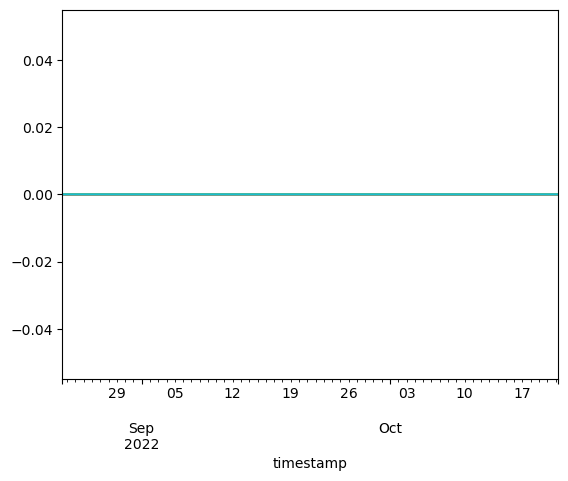

ADA (1439, 4)
ATOM (1439, 4)
BNB (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
MATIC (1439, 4)
SOL (1439, 4)
XRP (1439, 4)


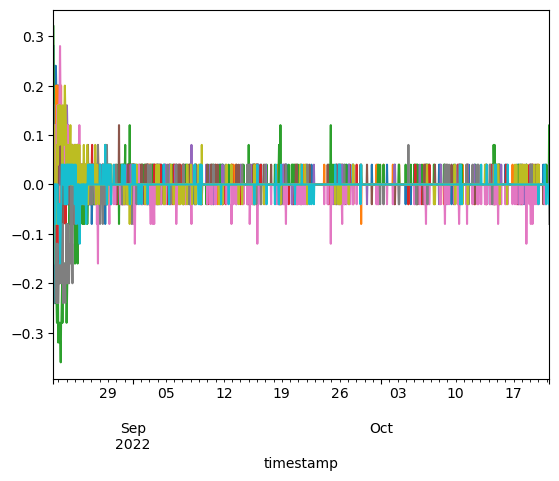

In [2]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd
import pandas_ta as ta

model = joblib.load('/home/jovyan/data/20221020_rank_nn.xz')
df = pd.read_pickle('/tmp/df_price_type_none.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()